In [55]:
import os
import cv2
import torch
import numpy as np
from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_boxes

def load_model(weights_path, cfg_path):
    checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
    model = Model(cfg=cfg_path, ch=3, nc=2)  # Ensure `nc` matches the number of classes in your model
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'].float().state_dict())
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint)
    else:
        raise TypeError("Checkpoint is not a dict or Model instance")
    return model

def iou(box1, box2):
    # Convert boxes to tensors if they're not already
    if not isinstance(box1, torch.Tensor):
        box1 = torch.tensor(box1)
    if not isinstance(box2, torch.Tensor):
        box2 = torch.tensor(box2)

    # Calculate intersection corners
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection and union areas
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def crop_center(image, box, crop_size=(96, 96)):
    # Convert tensor to integers if necessary
    if isinstance(box[0], torch.Tensor):
        box = [int(coord.item()) for coord in box]  # Convert each tensor element to an integer
    
    x_min, y_min, x_max, y_max = box
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    crop_width, crop_height = crop_size
    half_crop_width = crop_width // 2
    half_crop_height = crop_height // 2

    start_x = max(center_x - half_crop_width, 0)
    start_y = max(center_y - half_crop_height, 0)
    end_x = min(center_x + half_crop_width, image.shape[1])
    end_y = min(center_y + half_crop_height, image.shape[0])

    # Check if the crop dimensions are less than the desired size and adjust
    if (end_x - start_x) < crop_width:
        if start_x == 0:
            end_x = min(crop_width, image.shape[1])
        elif end_x == image.shape[1]:
            start_x = max(image.shape[1] - crop_width, 0)

    if (end_y - start_y) < crop_height:
        if start_y == 0:
            end_y = min(crop_height, image.shape[0])
        elif end_y == image.shape[0]:
            start_y = max(image.shape[0] - crop_height, 0)

    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image


def save_false_positives(images_folder, labels_folder, output_folder, model, iou_threshold=0.5, conf_threshold=0.7, similarity_threshold=0.4):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    image_files = [f for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    for image_file in image_files:
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue
        image_height, image_width = image.shape[:2]
        ground_truth_boxes = read_boxes_from_file(label_path, image_width, image_height)
        img = cv2.resize(image, (640, 640))
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device).float() / 255.0
        img = img.unsqueeze(0)
        print('Image preprocessing complete.')

        with torch.no_grad():
            results = model(img)
        predictions = non_max_suppression(results, conf_threshold, 0.45, max_det=1000)
        false_positives = []
        print('The prediction started working.')

        for pred in predictions:
            if pred.shape[0] == 0:
                continue
            for det in pred:
                x_min, y_min, x_max, y_max, conf = det[:5]
                print(f'Confidence: {conf}, Threshold: {conf_threshold}')
                if conf < conf_threshold:
                    continue
                pred_box = (x_min, y_min, x_max, y_max)
                iou_scores = [iou(pred_box, gt_box) for gt_box in ground_truth_boxes]
                if all(iou_score < iou_threshold for iou_score in iou_scores):
                    false_positives.append(pred_box)

        print(f'The false positives are: {false_positives}')
        for i, box in enumerate(false_positives):
            false_positive_image = crop_center(image, box, crop_size=(96, 96))
            output_path = os.path.join(output_folder, f'{os.path.splitext(image_file)[0]}_false_{i}.jpg')
            cv2.imwrite(output_path, false_positive_image)

# Example usage
weights_path = 'E:\\MSc Thesis\\Previous\\part2\\best.pt'
cfg_path = 'C:\\Users\\hp\\american\\yolov9\\models\\detect\\gelan-c.yaml'
images_folder = 'E:\\MSc Thesis\\tile_output2\\train\\images'
labels_folder = 'E:\\MSc Thesis\\tile_output2\\train\\labels'
output_folder = 'E:\\MSc Thesis\\Previous\\part2\\type\\false_predictions'

model = load_model(weights_path, cfg_path)
save_false_positives(images_folder, labels_folder, output_folder, model, iou_threshold=0.1, conf_threshold=0.1, similarity_threshold=0.2)


Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Image preprocessing complete.
The prediction started working.
Confidence: 0.9433739185333252, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9299952983856201, Threshold: 0.1
Confidence: 0.16402782499790192, Threshold: 0.1
Confidence: 0.14136739075183868, Threshold: 0.1
The false positives are: [(tensor(262.75842), tensor(0.03526), tensor(466.34436), tensor(32.53281)), (tensor(48.85678), tensor(-0.00117), tensor(224.10199), tensor(36.07792))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9293403625488281, Threshold: 0.1
Confidence: 0.9153239130973816, Threshold: 0.1
Confidence: 0.23909397423267365, Threshold: 0.1
The false positives are: [(tensor(27.65652), tensor(0.04443), tensor(209.51492), tensor(26.18570))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9438942074775696, Threshold: 0.1
Confidence: 0.9384883046150208, Threshold: 0.1
Confidence: 0.93592995

The prediction started working.
Confidence: 0.9356738328933716, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9187695980072021, Threshold: 0.1
Confidence: 0.2367849051952362, Threshold: 0.1
Confidence: 0.11479697376489639, Threshold: 0.1
The false positives are: [(tensor(227.28143), tensor(586.27661), tensor(441.28082), tensor(639.62744)), (tensor(598.27502), tensor(159.73271), tensor(639.85364), tensor(378.89545))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9434076547622681, Threshold: 0.1
Confidence: 0.1468619704246521, Threshold: 0.1
The false positives are: [(tensor(574.13660), tensor(252.48199), tensor(639.84827), tensor(387.07111))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9385523200035095, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9216026663780212, Threshold: 0.1
T

The prediction started working.
Confidence: 0.8891037702560425, Threshold: 0.1
Confidence: 0.8023568391799927, Threshold: 0.1
Confidence: 0.11550403386354446, Threshold: 0.1
The false positives are: [(tensor(-0.00526), tensor(10.36987), tensor(31.40663), tensor(150.85544)), (tensor(0.18755), tensor(539.80280), tensor(68.00696), tensor(639.69513))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9470905065536499, Threshold: 0.1
Confidence: 0.9083452820777893, Threshold: 0.1
Confidence: 0.1642136126756668, Threshold: 0.1
The false positives are: [(tensor(0.06242), tensor(413.94299), tensor(72.43578), tensor(604.31067)), (tensor(491.22052), tensor(608.70679), tensor(640.06696), tensor(639.71069))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9433146119117737, Threshold: 0.1
Confidence: 0.926146924495697, Threshold: 0.1
Confidence: 0.9249382615089417, Threshold: 0.1
Confidence: 0.9150390625, Threshold: 0.1
Confidence: 0.89676403999

The prediction started working.
Confidence: 0.9434427618980408, Threshold: 0.1
Confidence: 0.1333530992269516, Threshold: 0.1
The false positives are: [(tensor(81.06693), tensor(-0.00891), tensor(271.32388), tensor(36.22980))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9423771500587463, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.949097752571106, Threshold: 0.1
Confidence: 0.9366809129714966, Threshold: 0.1
Confidence: 0.8761217594146729, Threshold: 0.1
Confidence: 0.22723546624183655, Threshold: 0.1
Confidence: 0.11387200653553009, Threshold: 0.1
Confidence: 0.108738973736763, Threshold: 0.1
The false positives are: [(tensor(0.16023), tensor(92.78876), tensor(71.77794), tensor(288.17749)), (tensor(59.09116), tensor(-0.04910), tensor(294.61472), tensor(44.81877)), (tensor(582.09967), tensor(299.58289), tensor(639.82867), tensor(511.61035))]
Image preprocessing complete.
The predi

The prediction started working.
Confidence: 0.9087415933609009, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9287527203559875, Threshold: 0.1
Confidence: 0.9266453385353088, Threshold: 0.1
Confidence: 0.9109272360801697, Threshold: 0.1
Confidence: 0.6786191463470459, Threshold: 0.1
The false positives are: [(tensor(574.96875), tensor(82.61349), tensor(639.87842), tensor(236.57162))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9294173717498779, Threshold: 0.1
Confidence: 0.25906142592430115, Threshold: 0.1
Confidence: 0.11403467506170273, Threshold: 0.1
The false positives are: [(tensor(106.12560), tensor(-0.07558), tensor(339.00824), tensor(59.95528)), (tensor(0.12844), tensor(142.24011), tensor(54.45643), tensor(338.51929))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9535055160522461, Threshold: 0.1
Confidence: 0.926127552986145, Threshold: 0.1
Con

The prediction started working.
Confidence: 0.9517951011657715, Threshold: 0.1
Confidence: 0.9512584805488586, Threshold: 0.1
Confidence: 0.13262857496738434, Threshold: 0.1
The false positives are: [(tensor(35.32150), tensor(598.72766), tensor(171.57669), tensor(639.67444))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9545246362686157, Threshold: 0.1
Confidence: 0.951525092124939, Threshold: 0.1
Confidence: 0.9502302408218384, Threshold: 0.1
Confidence: 0.13210593163967133, Threshold: 0.1
The false positives are: [(tensor(0.04492), tensor(458.43161), tensor(31.81531), tensor(572.90771))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9246023297309875, Threshold: 0.1
Confidence: 0.9231988787651062, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9211375713348389, Threshold: 0.1
Confidence: 0.22852468490600586, Threshold: 0.1
The false positives are: [(tens

The prediction started working.
Confidence: 0.954983651638031, Threshold: 0.1
Confidence: 0.947444498538971, Threshold: 0.1
Confidence: 0.9453633427619934, Threshold: 0.1
Confidence: 0.9381588101387024, Threshold: 0.1
Confidence: 0.9297551512718201, Threshold: 0.1
Confidence: 0.9142621159553528, Threshold: 0.1
Confidence: 0.18864670395851135, Threshold: 0.1
Confidence: 0.13759838044643402, Threshold: 0.1
The false positives are: [(tensor(0.16022), tensor(0.10513), tensor(100.22363), tensor(112.92747)), (tensor(258.92914), tensor(-0.15462), tensor(412.11584), tensor(67.84772)), (tensor(406.03491), tensor(595.32544), tensor(601.29883), tensor(639.60352)), (tensor(567.22961), tensor(278.38293), tensor(639.80701), tensor(431.07855))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8777692317962646, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9232161641120911, Threshold: 0.1
Confidence: 0.

The prediction started working.
Confidence: 0.9438859224319458, Threshold: 0.1
Confidence: 0.9373238682746887, Threshold: 0.1
Confidence: 0.9365020990371704, Threshold: 0.1
Confidence: 0.9007473587989807, Threshold: 0.1
Confidence: 0.15870951116085052, Threshold: 0.1
The false positives are: [(tensor(548.08289), tensor(185.00647), tensor(639.79370), tensor(367.43890)), (tensor(551.66016), tensor(-0.00502), tensor(639.88208), tensor(50.74591))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9371040463447571, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8974002599716187, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9439214468002319, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9672005772590637, Threshold: 0.1
The false positives are: []
Imag

The prediction started working.
Confidence: 0.9358970522880554, Threshold: 0.1
Confidence: 0.921221911907196, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8908197283744812, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9382027983665466, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9383650422096252, Threshold: 0.1
Confidence: 0.8673233985900879, Threshold: 0.1
Confidence: 0.8150551319122314, Threshold: 0.1
Confidence: 0.1309577077627182, Threshold: 0.1
Confidence: 0.118134044110775, Threshold: 0.1
The false positives are: [(tensor(123.21809), tensor(-0.11110), tensor(311.54218), tensor(77.63347)), (tensor(301.14270), tensor(0.03788), tensor(475.78015), tensor(44.71794)), (tensor(580.38202), tensor(175.16737), tensor(640.01447), tensor(372.54712)), (tensor(588.40948), te

The prediction started working.
Confidence: 0.9171308279037476, Threshold: 0.1
Confidence: 0.9139819145202637, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9352664947509766, Threshold: 0.1
Confidence: 0.9211232662200928, Threshold: 0.1
Confidence: 0.9143385291099548, Threshold: 0.1
Confidence: 0.5961064696311951, Threshold: 0.1
Confidence: 0.20746929943561554, Threshold: 0.1
The false positives are: [(tensor(599.08698), tensor(346.05786), tensor(639.84564), tensor(436.45367)), (tensor(220.76129), tensor(0.04813), tensor(307.09698), tensor(19.72907))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9302080869674683, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9400544762611389, Threshold: 0.1
Confidence: 0.9344810843467712, Threshold: 0.1
Confidence: 0.9285060167312622, Threshold: 0.1
The false positives are: []
I

The prediction started working.
Confidence: 0.8799028992652893, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9145737886428833, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9223989844322205, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9504003524780273, Threshold: 0.1
Confidence: 0.9377528429031372, Threshold: 0.1
Confidence: 0.7171440720558167, Threshold: 0.1
Confidence: 0.1472320705652237, Threshold: 0.1
Confidence: 0.11470823734998703, Threshold: 0.1
The false positives are: [(tensor(0.08622), tensor(0.05381), tensor(80.10902), tensor(69.97448)), (tensor(607.74194), tensor(140.98807), tensor(639.83374), tensor(345.55151)), (tensor(0.14470), tensor(291.32312), tensor(62.26183), tensor(459.47876))]
Image preprocessing complete.
The prediction started working.
Confiden

The prediction started working.
Confidence: 0.915024995803833, Threshold: 0.1
Confidence: 0.9137566685676575, Threshold: 0.1
Confidence: 0.9068441987037659, Threshold: 0.1
Confidence: 0.11403373628854752, Threshold: 0.1
The false positives are: [(tensor(613.75397), tensor(550.09033), tensor(639.67645), tensor(582.45459))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9235934615135193, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9208973050117493, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8898246884346008, Threshold: 0.1
Confidence: 0.8887050747871399, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9200208783149719, Threshold: 0.1
Confidence: 0.8889264464378357, Threshold: 0.1
Confidence: 0.8507063984870911, Threshold: 0.1
The false posit

The prediction started working.
Confidence: 0.9392892122268677, Threshold: 0.1
Confidence: 0.9333117604255676, Threshold: 0.1
Confidence: 0.9300459623336792, Threshold: 0.1
Confidence: 0.9296154379844666, Threshold: 0.1
Confidence: 0.9281731247901917, Threshold: 0.1
Confidence: 0.895561933517456, Threshold: 0.1
Confidence: 0.8926349878311157, Threshold: 0.1
Confidence: 0.14154404401779175, Threshold: 0.1
Confidence: 0.1286817044019699, Threshold: 0.1
The false positives are: [(tensor(537.28516), tensor(625.39026), tensor(585.96631), tensor(639.79309))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9245767593383789, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9201807379722595, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9260522127151489, Threshold: 0.1
Confidence: 0.9246764183044434, Threshold: 0.1
The false p

The prediction started working.
Confidence: 0.9395272731781006, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9201316237449646, Threshold: 0.1
Confidence: 0.9045966863632202, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9255808591842651, Threshold: 0.1
Confidence: 0.8682228922843933, Threshold: 0.1
The false positives are: [(tensor(29.41212), tensor(-0.06898), tensor(125.90275), tensor(20.50906))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9240573048591614, Threshold: 0.1
Confidence: 0.9229755401611328, Threshold: 0.1
Confidence: 0.16208651661872864, Threshold: 0.1
The false positives are: [(tensor(577.98816), tensor(55.49413), tensor(639.88879), tensor(217.18309))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.924841046333313, Threshold: 0.1
Confidence: 0.8988630771636963, Thres

The prediction started working.
Confidence: 0.937760591506958, Threshold: 0.1
Confidence: 0.93619704246521, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9402521252632141, Threshold: 0.1
Confidence: 0.9401073455810547, Threshold: 0.1
Confidence: 0.9243021607398987, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9396259188652039, Threshold: 0.1
Confidence: 0.9369518756866455, Threshold: 0.1
Confidence: 0.8922711610794067, Threshold: 0.1
Confidence: 0.7149813771247864, Threshold: 0.1
Confidence: 0.1344635784626007, Threshold: 0.1
The false positives are: [(tensor(47.17764), tensor(599.76660), tensor(215.45932), tensor(639.57739)), (tensor(619.94501), tensor(-28.80579), tensor(639.86139), tensor(140.51147))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9494579434394836, Threshold: 0.1
The false positives are: []
Ima

The prediction started working.
Confidence: 0.8364497423171997, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.922588050365448, Threshold: 0.1
Confidence: 0.21542654931545258, Threshold: 0.1
The false positives are: [(tensor(570.39404), tensor(471.53757), tensor(639.76367), tensor(579.50024))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9297252893447876, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9356105923652649, Threshold: 0.1
Confidence: 0.9319761991500854, Threshold: 0.1
Confidence: 0.8513743281364441, Threshold: 0.1
The false positives are: [(tensor(217.99852), tensor(586.69824), tensor(379.11523), tensor(639.64795))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9360433220863342, Threshold: 0.1
Confidence: 0.9341879487037659, Threshold: 0.1
The false positives are: []
Image

The prediction started working.
Confidence: 0.9379114508628845, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9474875926971436, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9227333068847656, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9434942007064819, Threshold: 0.1
Confidence: 0.9382131695747375, Threshold: 0.1
Confidence: 0.9336257576942444, Threshold: 0.1
Confidence: 0.925815224647522, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9407814145088196, Threshold: 0.1
Confidence: 0.9277558326721191, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9540473222732544, Threshold: 0.1
The false positives are: []
Image preprocessing c

The prediction started working.
Confidence: 0.938169538974762, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9379872679710388, Threshold: 0.1
Confidence: 0.928154468536377, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9367212653160095, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9365729689598083, Threshold: 0.1
Confidence: 0.8427677750587463, Threshold: 0.1
The false positives are: [(tensor(584.45654), tensor(471.41553), tensor(639.69531), tensor(565.66113))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9341619610786438, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9542911052703857, Threshold: 0.1
Confidence: 0.951005756855011, Threshold: 0.1
Confidence: 0.94898682

The prediction started working.
Confidence: 0.9307594299316406, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9355573654174805, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9310657382011414, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9348969459533691, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9496945142745972, Threshold: 0.1
Confidence: 0.9177418947219849, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9368409514427185, Threshold: 0.1
Confidence: 0.811568558216095, Threshold: 0.1
Confidence: 0.3082226812839508, Threshold: 0.1
The false positives are: [(tensor(588.58081), tensor(96.23581), tensor(639.84521), tensor(224.15

The prediction started working.
Confidence: 0.9345048666000366, Threshold: 0.1
Confidence: 0.9321990013122559, Threshold: 0.1
Confidence: 0.899997353553772, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9392143487930298, Threshold: 0.1
Confidence: 0.9213186502456665, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9293711185455322, Threshold: 0.1
Confidence: 0.9253755211830139, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9363975524902344, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8595715761184692, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.931820809841156, Threshold: 0.1
Confidence: 0.9282414317131042, Threshold: 0.1
Con

The prediction started working.
Confidence: 0.9493879675865173, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9382513761520386, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9326945543289185, Threshold: 0.1
Confidence: 0.21445810794830322, Threshold: 0.1
The false positives are: [(tensor(514.35303), tensor(608.47980), tensor(640.93823), tensor(639.63776))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9377577900886536, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9274101853370667, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9369989037513733, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.94309228

The prediction started working.
Confidence: 0.9444570541381836, Threshold: 0.1
Confidence: 0.9335662126541138, Threshold: 0.1
Confidence: 0.18467754125595093, Threshold: 0.1
The false positives are: [(tensor(625.30518), tensor(89.61688), tensor(639.89258), tensor(249.23529))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9390090107917786, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9458023905754089, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9398074746131897, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9292687773704529, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.935479998588562, Threshold: 0.1
Confidence: 0.8924585580825806, Threshold: 0.1
The false positives 

The prediction started working.
Confidence: 0.9271891117095947, Threshold: 0.1
Confidence: 0.9155564904212952, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9089207053184509, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.940334677696228, Threshold: 0.1
Confidence: 0.9286433458328247, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9336503744125366, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9354747533798218, Threshold: 0.1
Confidence: 0.19412551820278168, Threshold: 0.1
The false positives are: [(tensor(588.20508), tensor(419.23389), tensor(639.82935), tensor(598.09814))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.936654269695282, Threshold: 0.1
Confidence: 0.935070

The prediction started working.
Confidence: 0.9235643744468689, Threshold: 0.1
Confidence: 0.9065792560577393, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9351752400398254, Threshold: 0.1
Confidence: 0.9310265779495239, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9379042387008667, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9244110584259033, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9339070320129395, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9388129115104675, Threshold: 0.1
Confidence: 0.9377708435058594, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confi

The prediction started working.
Confidence: 0.9449683427810669, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9382405281066895, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.944427490234375, Threshold: 0.1
Confidence: 0.9261026382446289, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9449385404586792, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9472224712371826, Threshold: 0.1
Confidence: 0.9380581974983215, Threshold: 0.1
Confidence: 0.28309524059295654, Threshold: 0.1
The false positives are: [(tensor(-0.07211), tensor(107.68150), tensor(17.78674), tensor(203.85519))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9376546144485474, Threshold: 0.1
The false positives a

The prediction started working.
Confidence: 0.9387486577033997, Threshold: 0.1
Confidence: 0.9256077408790588, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9314899444580078, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9375985264778137, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9360267519950867, Threshold: 0.1
Confidence: 0.8586699962615967, Threshold: 0.1
The false positives are: [(tensor(72.57068), tensor(566.71777), tensor(208.25745), tensor(639.73901))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9428104758262634, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9438896775245667, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The predi

The prediction started working.
Confidence: 0.9562048316001892, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9234204292297363, Threshold: 0.1
Confidence: 0.18150809407234192, Threshold: 0.1
The false positives are: [(tensor(565.59277), tensor(350.08411), tensor(639.86157), tensor(557.18970))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9342502951622009, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9445459246635437, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9416547417640686, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9287745356559753, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.93546462

The prediction started working.
Confidence: 0.9356874227523804, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.922598123550415, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9184404611587524, Threshold: 0.1
Confidence: 0.9081923961639404, Threshold: 0.1
Confidence: 0.9061627984046936, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9298617243766785, Threshold: 0.1
Confidence: 0.8618474006652832, Threshold: 0.1
Confidence: 0.1978699117898941, Threshold: 0.1
The false positives are: [(tensor(474.86017), tensor(0.04140), tensor(570.39752), tensor(15.76561))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9454371929168701, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.944257915

The prediction started working.
Confidence: 0.9245592355728149, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9307798743247986, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9329428672790527, Threshold: 0.1
Confidence: 0.921929121017456, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9441028833389282, Threshold: 0.1
Confidence: 0.9215483069419861, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9362748861312866, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9435975551605225, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9469362497329712, Threshold: 0.1
The fa

The prediction started working.
Confidence: 0.934240996837616, Threshold: 0.1
Confidence: 0.9308435916900635, Threshold: 0.1
Confidence: 0.9236225485801697, Threshold: 0.1
The false positives are: [(tensor(538.12646), tensor(561.28455), tensor(639.82642), tensor(639.84460))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9369217753410339, Threshold: 0.1
Confidence: 0.5152721405029297, Threshold: 0.1
The false positives are: [(tensor(603.65295), tensor(299.17804), tensor(639.85437), tensor(459.37396))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9377334713935852, Threshold: 0.1
Confidence: 0.9369810819625854, Threshold: 0.1
Confidence: 0.22548772394657135, Threshold: 0.1
Confidence: 0.14392346143722534, Threshold: 0.1
The false positives are: [(tensor(612.31293), tensor(68.55750), tensor(639.87164), tensor(267.17050)), (tensor(0.07852), tensor(196.27615), tensor(138.34399), tensor(345.53055))]
Image preprocessing complete.
The

The prediction started working.
Confidence: 0.9402903914451599, Threshold: 0.1
Confidence: 0.9364138841629028, Threshold: 0.1
Confidence: 0.9324546456336975, Threshold: 0.1
Confidence: 0.9027113914489746, Threshold: 0.1
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9408025145530701, Threshold: 0.1
Confidence: 0.1006769984960556, Threshold: 0.1
The false positives are: [(tensor(546.03308), tensor(0.04880), tensor(640.27966), tensor(53.48489))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9269207715988159, Threshold: 0.1
Confidence: 0.7295868396759033, Threshold: 0.1
Confidence: 0.16951076686382294, Threshold: 0.1
The false positives are: [(tensor(142.37976), tensor(-0.08884), tensor(288.20770), tensor(75.10903)), (tensor(556.11914), tensor(131.04388), tensor(639.85559), tensor(375.19244))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.935335099697113, Threshold: 0.1
Con

The prediction started working.
Confidence: 0.946039080619812, Threshold: 0.1
Confidence: 0.9449551701545715, Threshold: 0.1
Confidence: 0.9272250533103943, Threshold: 0.1
Confidence: 0.38172462582588196, Threshold: 0.1
Confidence: 0.2398330718278885, Threshold: 0.1
Confidence: 0.10751999914646149, Threshold: 0.1
The false positives are: [(tensor(536.99701), tensor(0.01265), tensor(639.85272), tensor(33.55442)), (tensor(-0.08085), tensor(139.97916), tensor(18.07727), tensor(273.36234))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9326215386390686, Threshold: 0.1
Confidence: 0.9306840300559998, Threshold: 0.1
Confidence: 0.9301176071166992, Threshold: 0.1
Confidence: 0.9252219200134277, Threshold: 0.1
Confidence: 0.29484131932258606, Threshold: 0.1
Confidence: 0.17565324902534485, Threshold: 0.1
The false positives are: [(tensor(453.70532), tensor(-0.08853), tensor(638.10327), tensor(72.52577)), (tensor(602.73096), tensor(221.53592), tensor(639.73828), te

In [56]:
import os
import cv2
import torch
import numpy as np
from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_boxes

def load_model(weights_path, cfg_path):
    checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
    model = Model(cfg=cfg_path, ch=3, nc=2)  # Ensure `nc` matches the number of classes in your model
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'].float().state_dict())
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint)
    else:
        raise TypeError("Checkpoint is not a dict or Model instance")
    return model

def iou(box1, box2):
    # Convert boxes to tensors if they're not already
    if not isinstance(box1, torch.Tensor):
        box1 = torch.tensor(box1)
    if not isinstance(box2, torch.Tensor):
        box2 = torch.tensor(box2)

    # Calculate intersection corners
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection and union areas
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def crop_center(image, box, crop_size=(96, 96)):
    # Convert tensor to integers if necessary
    if isinstance(box[0], torch.Tensor):
        box = [int(coord.item()) for coord in box]  # Convert each tensor element to an integer
    
    x_min, y_min, x_max, y_max = box
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    crop_width, crop_height = crop_size
    half_crop_width = crop_width // 2
    half_crop_height = crop_height // 2

    start_x = max(center_x - half_crop_width, 0)
    start_y = max(center_y - half_crop_height, 0)
    end_x = min(center_x + half_crop_width, image.shape[1])
    end_y = min(center_y + half_crop_height, image.shape[0])

    # Check if the crop dimensions are less than the desired size and adjust
    if (end_x - start_x) < crop_width:
        if start_x == 0:
            end_x = min(crop_width, image.shape[1])
        elif end_x == image.shape[1]:
            start_x = max(image.shape[1] - crop_width, 0)

    if (end_y - start_y) < crop_height:
        if start_y == 0:
            end_y = min(crop_height, image.shape[0])
        elif end_y == image.shape[0]:
            start_y = max(image.shape[0] - crop_height, 0)

    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image


def save_false_positives(images_folder, labels_folder, output_folder, model, iou_threshold=0.5, conf_threshold=0.7, similarity_threshold=0.4):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    image_files = [f for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    for image_file in image_files:
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue
        image_height, image_width = image.shape[:2]
        ground_truth_boxes = read_boxes_from_file(label_path, image_width, image_height)
        img = cv2.resize(image, (640, 640))
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device).float() / 255.0
        img = img.unsqueeze(0)
        print('Image preprocessing complete.')

        with torch.no_grad():
            results = model(img)
        predictions = non_max_suppression(results, conf_threshold, 0.45, max_det=1000)
        false_positives = []
        print('The prediction started working.')

        for pred in predictions:
            if pred.shape[0] == 0:
                continue
            for det in pred:
                x_min, y_min, x_max, y_max, conf = det[:5]
                print(f'Confidence: {conf}, Threshold: {conf_threshold}')
                if conf < conf_threshold:
                    continue
                pred_box = (x_min, y_min, x_max, y_max)
                iou_scores = [iou(pred_box, gt_box) for gt_box in ground_truth_boxes]
                if all(iou_score < iou_threshold for iou_score in iou_scores):
                    false_positives.append(pred_box)

        print(f'The false positives are: {false_positives}')
        for i, box in enumerate(false_positives):
            false_positive_image = crop_center(image, box, crop_size=(96, 96))
            output_path = os.path.join(output_folder, f'{os.path.splitext(image_file)[0]}_false_{i}.jpg')
            cv2.imwrite(output_path, false_positive_image)

# Example usage
weights_path = 'E:\\MSc Thesis\\Previous\\part2\\best.pt'
cfg_path = 'C:\\Users\\hp\\american\\yolov9\\models\\detect\\gelan-c.yaml'
images_folder = 'E:\\MSc Thesis\\tile_output2\\val\\images'
labels_folder = 'E:\\MSc Thesis\\tile_output2\\val\\labels'
output_folder = 'E:\\MSc Thesis\\Previous\\part2\\type\\false_predictions'

model = load_model(weights_path, cfg_path)
save_false_positives(images_folder, labels_folder, output_folder, model, iou_threshold=0.05, conf_threshold=0.05, similarity_threshold=0.2)


Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Image preprocessing complete.
The prediction started working.
Confidence: 0.943008542060852, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9452346563339233, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9502375721931458, Threshold: 0.05
Confidence: 0.12004565447568893, Threshold: 0.05
The false positives are: [(tensor(605.62585), tensor(200.01959), tensor(639.75879), tensor(441.22211))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9306737184524536, Threshold: 0.05
Confidence: 0.13643020391464233, Threshold: 0.05
Confidence: 0.10008979588747025, Threshold: 0.05
The false positives are: [(tensor(489.73291), tensor(585.88324), tensor(639.75940), tensor(639.62921)), (tensor(-0.05463), tensor(398.29053), tensor(20.96112), tensor(566.93475))]
Image preprocessing complete.
The prediction started working.
Confidence: 

The prediction started working.
Confidence: 0.880452573299408, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8945491909980774, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8958895206451416, Threshold: 0.05
Confidence: 0.25904715061187744, Threshold: 0.05
The false positives are: [(tensor(0.00157), tensor(531.62073), tensor(32.80312), tensor(639.61438))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.904598593711853, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9305211305618286, Threshold: 0.05
Confidence: 0.9023789167404175, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9445770978927612, Threshold: 0.05
Confidence: 0.5171221494674683, Threshold: 0.05
The false posi

The prediction started working.
Confidence: 0.9378980398178101, Threshold: 0.05
Confidence: 0.6812257170677185, Threshold: 0.05
Confidence: 0.15962862968444824, Threshold: 0.05
Confidence: 0.09735098481178284, Threshold: 0.05
The false positives are: [(tensor(-0.00966), tensor(58.34925), tensor(50.70546), tensor(222.47760)), (tensor(591.86682), tensor(122.03189), tensor(639.76404), tensor(320.36902)), (tensor(97.67224), tensor(0.07991), tensor(288.37445), tensor(26.08301))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9301301836967468, Threshold: 0.05
Confidence: 0.9265000224113464, Threshold: 0.05
Confidence: 0.5628368258476257, Threshold: 0.05
Confidence: 0.06763490289449692, Threshold: 0.05
The false positives are: [(tensor(0.15699), tensor(120.53714), tensor(32.54055), tensor(319.58160)), (tensor(543.54889), tensor(1.07085), tensor(639.95453), tensor(160.57039))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9298997521400

The prediction started working.
Confidence: 0.9388317465782166, Threshold: 0.05
Confidence: 0.8617483973503113, Threshold: 0.05
Confidence: 0.08010102808475494, Threshold: 0.05
Confidence: 0.053046923130750656, Threshold: 0.05
The false positives are: [(tensor(539.96948), tensor(99.89148), tensor(639.85132), tensor(355.18854)), (tensor(108.34079), tensor(564.66443), tensor(327.33087), tensor(639.68958))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9522801041603088, Threshold: 0.05
Confidence: 0.9209725260734558, Threshold: 0.05
The false positives are: [(tensor(307.29132), tensor(551.12506), tensor(472.16620), tensor(639.73712))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9519822001457214, Threshold: 0.05
Confidence: 0.9217700362205505, Threshold: 0.05
Confidence: 0.900373101234436, Threshold: 0.05
Confidence: 0.055637214332818985, Threshold: 0.05
The false positives are: [(tensor(-0.01151), tensor(112.96509), tensor(37.7

The prediction started working.
Confidence: 0.9421998858451843, Threshold: 0.05
Confidence: 0.216454416513443, Threshold: 0.05
Confidence: 0.18157140910625458, Threshold: 0.05
Confidence: 0.10993825644254684, Threshold: 0.05
Confidence: 0.052792806178331375, Threshold: 0.05
The false positives are: [(tensor(398.09381), tensor(579.71661), tensor(619.17218), tensor(639.69611)), (tensor(587.40088), tensor(334.34766), tensor(639.78540), tensor(538.90417)), (tensor(16.66051), tensor(588.98419), tensor(206.48972), tensor(639.55597)), (tensor(-0.01743), tensor(496.82178), tensor(35.15422), tensor(638.97791))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9215765595436096, Threshold: 0.05
Confidence: 0.8356693983078003, Threshold: 0.05
Confidence: 0.5050597786903381, Threshold: 0.05
Confidence: 0.08978049457073212, Threshold: 0.05
Confidence: 0.06981205940246582, Threshold: 0.05
Confidence: 0.0679200291633606, Threshold: 0.05
Confidence: 0.05113093927502632, Thres

The prediction started working.
Confidence: 0.9456773400306702, Threshold: 0.05
Confidence: 0.9417772889137268, Threshold: 0.05
Confidence: 0.08323110640048981, Threshold: 0.05
Confidence: 0.06361199915409088, Threshold: 0.05
The false positives are: [(tensor(-0.01918), tensor(90.84847), tensor(59.45257), tensor(289.99271)), (tensor(11.44705), tensor(0.05610), tensor(223.39270), tensor(67.44306))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9337076544761658, Threshold: 0.05
Confidence: 0.9272516369819641, Threshold: 0.05
Confidence: 0.08082649856805801, Threshold: 0.05
Confidence: 0.06114236265420914, Threshold: 0.05
The false positives are: [(tensor(0.14901), tensor(138.00977), tensor(63.63478), tensor(352.01929)), (tensor(404.22131), tensor(0.04224), tensor(610.80420), tensor(18.40602))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9307956695556641, Threshold: 0.05
Confidence: 0.9056563973426819, Threshold: 0.05
Confidenc

The prediction started working.
Confidence: 0.9407563805580139, Threshold: 0.05
Confidence: 0.10321496427059174, Threshold: 0.05
The false positives are: [(tensor(610.73621), tensor(162.34015), tensor(639.85925), tensor(426.79877))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9352744817733765, Threshold: 0.05
Confidence: 0.9256130456924438, Threshold: 0.05
Confidence: 0.653409481048584, Threshold: 0.05
Confidence: 0.05807213485240936, Threshold: 0.05
The false positives are: [(tensor(-0.31903), tensor(349.50885), tensor(138.55023), tensor(548.31158)), (tensor(590.90613), tensor(255.08054), tensor(639.85107), tensor(454.69974)), (tensor(-0.01394), tensor(541.33337), tensor(73.85584), tensor(639.50403))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8869078159332275, Threshold: 0.05
Confidence: 0.8687285780906677, Threshold: 0.05
Confidence: 0.8513478636741638, Threshold: 0.05
Confidence: 0.8019363880157471, Threshold: 0.05
Co

The prediction started working.
Confidence: 0.9173388481140137, Threshold: 0.05
Confidence: 0.22454385459423065, Threshold: 0.05
Confidence: 0.16909334063529968, Threshold: 0.05
Confidence: 0.10126519948244095, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8719420433044434, Threshold: 0.05
Confidence: 0.8434451222419739, Threshold: 0.05
Confidence: 0.4550469219684601, Threshold: 0.05
Confidence: 0.31118690967559814, Threshold: 0.05
Confidence: 0.15489159524440765, Threshold: 0.05
Confidence: 0.12424345314502716, Threshold: 0.05
Confidence: 0.09743603318929672, Threshold: 0.05
The false positives are: [(tensor(347.26807), tensor(134.82269), tensor(505.42102), tensor(328.65579)), (tensor(557.86737), tensor(122.15137), tensor(639.85809), tensor(336.44193)), (tensor(363.93542), tensor(0.06591), tensor(564.00293), tensor(28.94618)), (tensor(566.78809), tensor(-0.03411), tensor(639.85059), tensor(49.49832)), (tensor(60

The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8985676765441895, Threshold: 0.05
Confidence: 0.10975112020969391, Threshold: 0.05
The false positives are: [(tensor(-0.01661), tensor(388.51437), tensor(48.81950), tensor(481.97208))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.898192822933197, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8045833706855774, Threshold: 0.05
Confidence: 0.225084125995636, Threshold: 0.05
Confidence: 0.05414960905909538, Threshold: 0.05
The false positives are: [(tensor(0.61502), tensor(-0.15832), tensor(168.56223), tensor(81.03537)), (tensor(0.10748), tensor(-0.03073), tensor(72.76767), tensor(30.60612))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9398297071456909, Threshold: 0.05
The false positives are: []
Image preprocessing compl

The prediction started working.
Confidence: 0.9149277806282043, Threshold: 0.05
Confidence: 0.9105973839759827, Threshold: 0.05
Confidence: 0.13165722787380219, Threshold: 0.05
Confidence: 0.1061706468462944, Threshold: 0.05
The false positives are: [(tensor(238.02869), tensor(598.66431), tensor(439.25739), tensor(639.59692)), (tensor(-0.02494), tensor(-0.54939), tensor(31.17704), tensor(157.89836))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9448427557945251, Threshold: 0.05
Confidence: 0.9410119652748108, Threshold: 0.05
Confidence: 0.9018188714981079, Threshold: 0.05
Confidence: 0.3822862505912781, Threshold: 0.05
Confidence: 0.34918883442878723, Threshold: 0.05
Confidence: 0.11821813136339188, Threshold: 0.05
Confidence: 0.05905061960220337, Threshold: 0.05
The false positives are: [(tensor(-0.55391), tensor(0.04388), tensor(148.64330), tensor(37.79117)), (tensor(533.14423), tensor(565.84180), tensor(639.83502), tensor(639.73096))]
Image preprocessi

The prediction started working.
Confidence: 0.926916241645813, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9445315003395081, Threshold: 0.05
Confidence: 0.9357109069824219, Threshold: 0.05
Confidence: 0.9340511560440063, Threshold: 0.05
Confidence: 0.6805858016014099, Threshold: 0.05
Confidence: 0.2955497205257416, Threshold: 0.05
Confidence: 0.05789543315768242, Threshold: 0.05
The false positives are: [(tensor(149.04221), tensor(573.23352), tensor(281.71970), tensor(639.89258)), (tensor(418.49915), tensor(0.04895), tensor(552.29828), tensor(54.25240)), (tensor(419.04755), tensor(-0.05048), tensor(599.29309), tensor(119.22811))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9044730067253113, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9453915953636169, Threshold: 0.05
The false positives are: []
Image prep

The prediction started working.
Confidence: 0.9380935430526733, Threshold: 0.05
Confidence: 0.9307937026023865, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.7583029866218567, Threshold: 0.05
Confidence: 0.0658654272556305, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9289140105247498, Threshold: 0.05
Confidence: 0.8386315107345581, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9376992583274841, Threshold: 0.05
Confidence: 0.912412166595459, Threshold: 0.05
The false positives are: [(tensor(156.79440), tensor(-0.05684), tensor(222.75214), tensor(93.53857))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8718868494033813, Threshold: 0.05
Confidence: 0.10431942343711853, Threshold: 0.05
The false positives are: [(tensor(0.15572), tensor(68.

The prediction started working.
Confidence: 0.8184620141983032, Threshold: 0.05
Confidence: 0.21414534747600555, Threshold: 0.05
Confidence: 0.13857313990592957, Threshold: 0.05
Confidence: 0.10042501240968704, Threshold: 0.05
Confidence: 0.08674567192792892, Threshold: 0.05
Confidence: 0.06972813606262207, Threshold: 0.05
Confidence: 0.05567663535475731, Threshold: 0.05
The false positives are: [(tensor(321.01978), tensor(544.29663), tensor(555.99170), tensor(639.62061)), (tensor(-0.00840), tensor(420.29471), tensor(84.15594), tensor(635.88672)), (tensor(73.46860), tensor(604.17773), tensor(347.55014), tensor(639.61829)), (tensor(-0.01931), tensor(232.18001), tensor(56.47821), tensor(429.93048)), (tensor(553.69409), tensor(594.07715), tensor(639.86035), tensor(639.70740)), (tensor(0.09902), tensor(-0.04354), tensor(73.43883), tensor(98.80665))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9397427439689636, Threshold: 0.05
Confidence: 0.11760766059160233,

The prediction started working.
Confidence: 0.935297429561615, Threshold: 0.05
Confidence: 0.0834815576672554, Threshold: 0.05
Confidence: 0.0621035099029541, Threshold: 0.05
The false positives are: [(tensor(92.30103), tensor(0.03743), tensor(284.81732), tensor(48.52919)), (tensor(0.16575), tensor(1.44728), tensor(114.34792), tensor(223.99100))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9284417629241943, Threshold: 0.05
Confidence: 0.17609846591949463, Threshold: 0.05
Confidence: 0.06539475172758102, Threshold: 0.05
Confidence: 0.06497656553983688, Threshold: 0.05
Confidence: 0.05083216726779938, Threshold: 0.05
The false positives are: [(tensor(-0.30141), tensor(380.57404), tensor(172.73051), tensor(608.98102)), (tensor(71.10571), tensor(466.21121), tensor(304.98648), tensor(639.69678))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8965084552764893, Threshold: 0.05
The false positives are: []
Image preprocessing complet

The prediction started working.
Confidence: 0.9423524737358093, Threshold: 0.05
Confidence: 0.10802916437387466, Threshold: 0.05
Confidence: 0.08789453655481339, Threshold: 0.05
Confidence: 0.056545235216617584, Threshold: 0.05
The false positives are: [(tensor(562.89771), tensor(-0.01973), tensor(639.86182), tensor(51.51929)), (tensor(557.53552), tensor(437.75848), tensor(639.86157), tensor(636.49554)), (tensor(297.35516), tensor(0.05062), tensor(447.98303), tensor(21.59439))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9397362470626831, Threshold: 0.05
Confidence: 0.3245932459831238, Threshold: 0.05
The false positives are: [(tensor(344.60760), tensor(0.03106), tensor(519.11182), tensor(42.68464))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9535083770751953, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9228293299674988, Threshold: 0.05
Confidence

The prediction started working.
Confidence: 0.8917340040206909, Threshold: 0.05
Confidence: 0.06792262196540833, Threshold: 0.05
The false positives are: [(tensor(544.80908), tensor(504.71924), tensor(639.82520), tensor(639.63867))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9391607046127319, Threshold: 0.05
Confidence: 0.07255527377128601, Threshold: 0.05
The false positives are: [(tensor(-0.18170), tensor(215.36737), tensor(155.02490), tensor(437.72058))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9374004006385803, Threshold: 0.05
Confidence: 0.4657784700393677, Threshold: 0.05
Confidence: 0.2576960325241089, Threshold: 0.05
Confidence: 0.06902851909399033, Threshold: 0.05
The false positives are: [(tensor(221.57434), tensor(-0.12638), tensor(444.94269), tensor(60.16595)), (tensor(127.53249), tensor(589.95691), tensor(385.70032), tensor(639.64197)), (tensor(0.00084), tensor(58.25443), tensor(51.79816), tensor(250.49536

The prediction started working.
Confidence: 0.497968852519989, Threshold: 0.05
Confidence: 0.10385431349277496, Threshold: 0.05
The false positives are: [(tensor(502.74036), tensor(145.06308), tensor(631.43384), tensor(269.91333))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9354024529457092, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9075850248336792, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9436389803886414, Threshold: 0.05
Confidence: 0.9419385194778442, Threshold: 0.05
Confidence: 0.9320739507675171, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.31319689750671387, Threshold: 0.05
Confidence: 0.053550101816654205, Threshold: 0.05
Confidence: 0.05223474279046059, Threshold: 0.05
The false positives are: [(tensor(498.41553), te

The prediction started working.
Confidence: 0.8763813376426697, Threshold: 0.05
Confidence: 0.6456497311592102, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9237720966339111, Threshold: 0.05
Confidence: 0.10898595303297043, Threshold: 0.05
The false positives are: [(tensor(-0.57132), tensor(584.19086), tensor(133.13446), tensor(639.78693))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8249729871749878, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.916864812374115, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9372320175170898, Threshold: 0.05
Confidence: 0.9327582120895386, Threshold: 0.05
Confidence: 0.9121915102005005, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence:

The prediction started working.
Confidence: 0.9196885228157043, Threshold: 0.05
Confidence: 0.8847542405128479, Threshold: 0.05
Confidence: 0.6490159630775452, Threshold: 0.05
Confidence: 0.05102669447660446, Threshold: 0.05
The false positives are: [(tensor(547.24274), tensor(0.13824), tensor(639.85785), tensor(130.63663)), (tensor(500.40707), tensor(163.14481), tensor(639.76062), tensor(394.23947))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.928382396697998, Threshold: 0.05
Confidence: 0.052591919898986816, Threshold: 0.05
The false positives are: [(tensor(-0.00043), tensor(1.38182), tensor(93.98426), tensor(223.56288))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8315237760543823, Threshold: 0.05
Confidence: 0.12412922084331512, Threshold: 0.05
Confidence: 0.11680090427398682, Threshold: 0.05
The false positives are: [(tensor(-1.17361), tensor(613.55798), tensor(192.07718), tensor(639.73132)), (tensor(0.05809), tensor(

The prediction started working.
Confidence: 0.9035134315490723, Threshold: 0.05
Confidence: 0.8473952412605286, Threshold: 0.05
The false positives are: [(tensor(573.55957), tensor(229.73569), tensor(639.86084), tensor(384.16434))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9306511878967285, Threshold: 0.05
Confidence: 0.9178580641746521, Threshold: 0.05
Confidence: 0.20342232286930084, Threshold: 0.05
The false positives are: [(tensor(0.02886), tensor(543.63904), tensor(93.37483), tensor(639.72119))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.939227819442749, Threshold: 0.05
Confidence: 0.9218040108680725, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.7758135199546814, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.933978259563446, Threshold: 0.05
Confidence: 0.27907982468605

The prediction started working.
Confidence: 0.89637291431427, Threshold: 0.05
Confidence: 0.741914689540863, Threshold: 0.05
The false positives are: [(tensor(494.90414), tensor(0.10405), tensor(640.07043), tensor(133.27953))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.6285348534584045, Threshold: 0.05
Confidence: 0.563947856426239, Threshold: 0.05
Confidence: 0.17075349390506744, Threshold: 0.05
Confidence: 0.055647727102041245, Threshold: 0.05
The false positives are: [(tensor(126.01233), tensor(-0.13527), tensor(387.12878), tensor(81.16888)), (tensor(580.31006), tensor(145.50380), tensor(639.80579), tensor(396.17834)), (tensor(0.00449), tensor(-0.00106), tensor(78.38660), tensor(122.96969))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9212276935577393, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9413170218467712, Threshold: 0.05
Confidence: 0.0

The prediction started working.
Confidence: 0.9396229386329651, Threshold: 0.05
Confidence: 0.9272567629814148, Threshold: 0.05
Confidence: 0.7691469192504883, Threshold: 0.05
Confidence: 0.1080925390124321, Threshold: 0.05
The false positives are: [(tensor(22.81946), tensor(534.95215), tensor(223.95709), tensor(639.57837)), (tensor(170.42403), tensor(0.07267), tensor(379.97003), tensor(37.36363))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8871461153030396, Threshold: 0.05
Confidence: 0.3526191711425781, Threshold: 0.05
Confidence: 0.1989930123090744, Threshold: 0.05
Confidence: 0.1755223274230957, Threshold: 0.05
Confidence: 0.12761984765529633, Threshold: 0.05
Confidence: 0.0889408066868782, Threshold: 0.05
Confidence: 0.0830845758318901, Threshold: 0.05
Confidence: 0.07447777688503265, Threshold: 0.05
The false positives are: [(tensor(-0.01352), tensor(169.82782), tensor(56.74447), tensor(295.06039)), (tensor(277.75079), tensor(280.40033), tensor(42

The prediction started working.
Confidence: 0.1742842197418213, Threshold: 0.05
Confidence: 0.08582194894552231, Threshold: 0.05
The false positives are: [(tensor(597.43250), tensor(422.76233), tensor(639.82727), tensor(628.25671)), (tensor(0.15570), tensor(492.42505), tensor(54.35747), tensor(639.21057))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.938265860080719, Threshold: 0.05
Confidence: 0.09952223300933838, Threshold: 0.05
Confidence: 0.060275640338659286, Threshold: 0.05
Confidence: 0.06008608639240265, Threshold: 0.05
The false positives are: [(tensor(0.04191), tensor(110.62854), tensor(18.41956), tensor(271.29410)), (tensor(225.62090), tensor(-0.08909), tensor(460.97211), tensor(49.61448)), (tensor(0.05688), tensor(-0.31686), tensor(34.66453), tensor(103.05913))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9375010132789612, Threshold: 0.05
Confidence: 0.9359413981437683, Threshold: 0.05
Confidence: 0.923322975635

The prediction started working.
Confidence: 0.950293242931366, Threshold: 0.05
Confidence: 0.9483891129493713, Threshold: 0.05
Confidence: 0.09569793939590454, Threshold: 0.05
The false positives are: [(tensor(608.77100), tensor(292.30469), tensor(639.88391), tensor(441.39062))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9467868208885193, Threshold: 0.05
Confidence: 0.9152346849441528, Threshold: 0.05
Confidence: 0.2210114449262619, Threshold: 0.05
Confidence: 0.05564446747303009, Threshold: 0.05
The false positives are: [(tensor(-0.23213), tensor(612.80701), tensor(173.49088), tensor(639.73828))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8690673112869263, Threshold: 0.05
Confidence: 0.6373057961463928, Threshold: 0.05
Confidence: 0.16033215820789337, Threshold: 0.05
Confidence: 0.15372711420059204, Threshold: 0.05
Confidence: 0.1116848737001419, Threshold: 0.05
The false positives are: [(tensor(0.19175), tensor(71.0864

The prediction started working.
Confidence: 0.9489960670471191, Threshold: 0.05
Confidence: 0.9472478628158569, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9225308299064636, Threshold: 0.05
Confidence: 0.09253107756376266, Threshold: 0.05
The false positives are: [(tensor(220.91176), tensor(554.69556), tensor(384.69397), tensor(639.78467))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9474882483482361, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9555161595344543, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.7472894191741943, Threshold: 0.05
Confidence: 0.22524605691432953, Threshold: 0.05
Confidence: 0.0947548970580101, Threshold: 0.05
Confidence: 0.07958643138408661, Threshold: 0.05
The false positives are: [(tensor(368.97424), ten

The prediction started working.
Confidence: 0.8735352754592896, Threshold: 0.05
Confidence: 0.6931393146514893, Threshold: 0.05
Confidence: 0.20697170495986938, Threshold: 0.05
Confidence: 0.1757129579782486, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9361063241958618, Threshold: 0.05
Confidence: 0.7185519337654114, Threshold: 0.05
Confidence: 0.40770116448402405, Threshold: 0.05
Confidence: 0.18309026956558228, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9327062368392944, Threshold: 0.05
Confidence: 0.22384458780288696, Threshold: 0.05
The false positives are: [(tensor(292.92645), tensor(591.48907), tensor(543.77087), tensor(639.68048))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9496449828147888, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.


The prediction started working.
Confidence: 0.9276759624481201, Threshold: 0.05
Confidence: 0.9162440299987793, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9345998764038086, Threshold: 0.05
Confidence: 0.7550071477890015, Threshold: 0.05
Confidence: 0.5019266605377197, Threshold: 0.05
Confidence: 0.06817308068275452, Threshold: 0.05
The false positives are: [(tensor(606.48938), tensor(68.11512), tensor(639.86328), tensor(210.66089)), (tensor(-0.01415), tensor(365.59949), tensor(28.38725), tensor(501.86536)), (tensor(331.70001), tensor(250.92975), tensor(510.34491), tensor(415.76501))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9310977458953857, Threshold: 0.05
Confidence: 0.5208839178085327, Threshold: 0.05
Confidence: 0.10261046886444092, Threshold: 0.05
The false positives are: [(tensor(267.69348), tensor(613.27979), tensor(363.95850), tensor(639.81152)), (tensor(0.13264), ten

The prediction started working.
Confidence: 0.6459692120552063, Threshold: 0.05
Confidence: 0.6331529021263123, Threshold: 0.05
The false positives are: [(tensor(-0.02054), tensor(165.20480), tensor(23.02668), tensor(400.91629)), (tensor(553.88599), tensor(580.62305), tensor(639.85083), tensor(639.69946))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.6799551844596863, Threshold: 0.05
Confidence: 0.2311755269765854, Threshold: 0.05
Confidence: 0.11180474609136581, Threshold: 0.05
The false positives are: [(tensor(107.37000), tensor(580.83093), tensor(237.10309), tensor(639.51306)), (tensor(547.60962), tensor(13.36440), tensor(639.86597), tensor(225.45245)), (tensor(406.35974), tensor(161.75043), tensor(624.86536), tensor(383.80591))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9395829439163208, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.951823413372

The prediction started working.
Confidence: 0.9373704791069031, Threshold: 0.05
Confidence: 0.10460107773542404, Threshold: 0.05
Confidence: 0.08274989575147629, Threshold: 0.05
Confidence: 0.07426052540540695, Threshold: 0.05
The false positives are: [(tensor(577.36981), tensor(323.57977), tensor(639.84369), tensor(554.44763)), (tensor(0.02433), tensor(-8.76337), tensor(21.94494), tensor(122.18683)), (tensor(547.67773), tensor(35.02415), tensor(639.75525), tensor(234.09824))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9474673867225647, Threshold: 0.05
Confidence: 0.8210549354553223, Threshold: 0.05
Confidence: 0.12219461053609848, Threshold: 0.05
The false positives are: [(tensor(175.79118), tensor(181.55353), tensor(374.22089), tensor(363.73724))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8623736500740051, Threshold: 0.05
Confidence: 0.11768146604299545, Threshold: 0.05
Confidence: 0.09177180379629135, Threshold: 0.05

The prediction started working.
Confidence: 0.3769749402999878, Threshold: 0.05
Confidence: 0.17114557325839996, Threshold: 0.05
Confidence: 0.12351732701063156, Threshold: 0.05
The false positives are: [(tensor(455.59998), tensor(586.69153), tensor(640.03491), tensor(639.68640)), (tensor(130.29639), tensor(-0.08780), tensor(333.10855), tensor(77.93421))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9223050475120544, Threshold: 0.05
Confidence: 0.41738852858543396, Threshold: 0.05
Confidence: 0.13763464987277985, Threshold: 0.05
Confidence: 0.0578257255256176, Threshold: 0.05
The false positives are: [(tensor(202.96704), tensor(82.80219), tensor(412.94781), tensor(318.76498)), (tensor(574.59851), tensor(240.46188), tensor(639.85120), tensor(415.77261)), (tensor(-0.01035), tensor(127.95441), tensor(23.06397), tensor(329.07928))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9450469613075256, Threshold: 0.05
Confidence: 0.06408

The prediction started working.
Confidence: 0.9180910587310791, Threshold: 0.05
Confidence: 0.46819058060646057, Threshold: 0.05
Confidence: 0.057864997535943985, Threshold: 0.05
The false positives are: [(tensor(189.04266), tensor(-0.13704), tensor(347.13165), tensor(101.94344)), (tensor(208.79616), tensor(574.30444), tensor(378.46252), tensor(639.76929))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9367157220840454, Threshold: 0.05
Confidence: 0.45882201194763184, Threshold: 0.05
Confidence: 0.1044735535979271, Threshold: 0.05
The false positives are: [(tensor(562.14142), tensor(141.76598), tensor(639.86176), tensor(397.47693))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9306977987289429, Threshold: 0.05
Confidence: 0.0559464693069458, Threshold: 0.05
The false positives are: [(tensor(593.46936), tensor(545.53040), tensor(639.85242), tensor(639.52014))]
Image preprocessing complete.
The prediction started working.
Confi

The prediction started working.
Confidence: 0.9423699378967285, Threshold: 0.05
Confidence: 0.9382120370864868, Threshold: 0.05
Confidence: 0.9226040244102478, Threshold: 0.05
Confidence: 0.26372238993644714, Threshold: 0.05
Confidence: 0.10732463002204895, Threshold: 0.05
The false positives are: [(tensor(220.68405), tensor(603.09570), tensor(409.17563), tensor(639.73340)), (tensor(0.05100), tensor(540.37476), tensor(91.87827), tensor(639.69971))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9504433274269104, Threshold: 0.05
Confidence: 0.9321209788322449, Threshold: 0.05
Confidence: 0.8289609551429749, Threshold: 0.05
Confidence: 0.08151054382324219, Threshold: 0.05
Confidence: 0.0814749225974083, Threshold: 0.05
The false positives are: [(tensor(283.05945), tensor(586.28357), tensor(452.17957), tensor(639.57068)), (tensor(315.63809), tensor(-0.11122), tensor(474.79227), tensor(15.94494)), (tensor(603.54553), tensor(143.70670), tensor(639.85107), tensor

The prediction started working.
Confidence: 0.9209026098251343, Threshold: 0.05
Confidence: 0.7308292984962463, Threshold: 0.05
Confidence: 0.10089226812124252, Threshold: 0.05
Confidence: 0.09793021529912949, Threshold: 0.05
The false positives are: [(tensor(0.08176), tensor(496.17566), tensor(42.13379), tensor(639.63464)), (tensor(-0.04081), tensor(0.09714), tensor(50.65356), tensor(129.79233)), (tensor(286.59247), tensor(618.01398), tensor(459.71088), tensor(639.74872))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.950903058052063, Threshold: 0.05
Confidence: 0.7687875628471375, Threshold: 0.05
The false positives are: [(tensor(312.57458), tensor(-0.03768), tensor(498.56750), tensor(45.26799))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9346804022789001, Threshold: 0.05
Confidence: 0.9332391023635864, Threshold: 0.05
Confidence: 0.9283761382102966, Threshold: 0.05
Confidence: 0.9180653095245361, Threshold: 0.05
Confiden

The prediction started working.
Confidence: 0.6521839499473572, Threshold: 0.05
Confidence: 0.42113226652145386, Threshold: 0.05
Confidence: 0.08931924402713776, Threshold: 0.05
The false positives are: [(tensor(595.36163), tensor(505.60107), tensor(639.86090), tensor(639.79956)), (tensor(63.69193), tensor(608.06885), tensor(283.34592), tensor(639.75073))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9350947737693787, Threshold: 0.05
Confidence: 0.9314196109771729, Threshold: 0.05
Confidence: 0.928031861782074, Threshold: 0.05
Confidence: 0.926432192325592, Threshold: 0.05
Confidence: 0.14063556492328644, Threshold: 0.05
Confidence: 0.0510246716439724, Threshold: 0.05
The false positives are: [(tensor(0.11736), tensor(527.80225), tensor(28.08016), tensor(640.52856))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.7341200113296509, Threshold: 0.05
Confidence: 0.1480412632226944, Threshold: 0.05
Confidence: 0.12640899419784546, 

The prediction started working.
Confidence: 0.954470694065094, Threshold: 0.05
Confidence: 0.09382344782352448, Threshold: 0.05
The false positives are: [(tensor(433.27576), tensor(78.71257), tensor(524.07513), tensor(187.69466))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9554750919342041, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9532642364501953, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9551510214805603, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.25714004039764404, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9502493143081665, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.94

The prediction started working.
Confidence: 0.9470552206039429, Threshold: 0.05
Confidence: 0.9308496117591858, Threshold: 0.05
Confidence: 0.9208889007568359, Threshold: 0.05
Confidence: 0.061990149319171906, Threshold: 0.05
The false positives are: [(tensor(626.24951), tensor(241.18158), tensor(639.86450), tensor(324.64661))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9351121783256531, Threshold: 0.05
Confidence: 0.9227542877197266, Threshold: 0.05
Confidence: 0.9149011373519897, Threshold: 0.05
Confidence: 0.9094552397727966, Threshold: 0.05
Confidence: 0.6949596405029297, Threshold: 0.05
Confidence: 0.42872655391693115, Threshold: 0.05
Confidence: 0.06663364917039871, Threshold: 0.05
The false positives are: [(tensor(-0.07319), tensor(228.37074), tensor(19.30999), tensor(288.57776))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9299863576889038, Threshold: 0.05
The false positives are: []
Image preprocessing complete.


The prediction started working.
Confidence: 0.9186261892318726, Threshold: 0.05
Confidence: 0.9067952632904053, Threshold: 0.05
Confidence: 0.7802371382713318, Threshold: 0.05
Confidence: 0.5368403792381287, Threshold: 0.05
Confidence: 0.46494781970977783, Threshold: 0.05
The false positives are: [(tensor(32.08429), tensor(127.20645), tensor(157.41623), tensor(222.72357)), (tensor(486.49631), tensor(302.32007), tensor(639.91089), tensor(471.40515))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.7224943041801453, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9209888577461243, Threshold: 0.05
Confidence: 0.9207812547683716, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9182792901992798, Threshold: 0.05
Confidence: 0.9147992134094238, Threshold: 0.05
Confidence: 0.7938140034675598, Threshold: 0.05
Confidence: 0.64

The prediction started working.
Confidence: 0.9482409358024597, Threshold: 0.05
Confidence: 0.928703248500824, Threshold: 0.05
The false positives are: [(tensor(194.86835), tensor(249.55432), tensor(338.92444), tensor(391.10254))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9425428509712219, Threshold: 0.05
Confidence: 0.6922234892845154, Threshold: 0.05
The false positives are: [(tensor(608.81067), tensor(558.78802), tensor(639.47278), tensor(631.70172))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.931829035282135, Threshold: 0.05
Confidence: 0.9014775156974792, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.93764728307724, Threshold: 0.05
Confidence: 0.26168861985206604, Threshold: 0.05
Confidence: 0.20079289376735687, Threshold: 0.05
The false positives are: [(tensor(601.38440), tensor(318.16443), tensor(639.75916), tensor(505.88062)), (tensor(219.

The prediction started working.
Confidence: 0.9490004777908325, Threshold: 0.05
Confidence: 0.9461466670036316, Threshold: 0.05
Confidence: 0.8067402243614197, Threshold: 0.05
The false positives are: [(tensor(303.52774), tensor(-0.08647), tensor(367.81863), tensor(30.66256))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9099231362342834, Threshold: 0.05
Confidence: 0.9069687128067017, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9178749918937683, Threshold: 0.05
Confidence: 0.8584821820259094, Threshold: 0.05
Confidence: 0.46319660544395447, Threshold: 0.05
The false positives are: [(tensor(407.66321), tensor(285.10562), tensor(528.03418), tensor(413.78903))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9203940033912659, Threshold: 0.05
Confidence: 0.8765152096748352, Threshold: 0.05
Confidence: 0.3131868243217468, Threshold: 0.05
Confidence: 0.08152

The prediction started working.
Confidence: 0.9011743068695068, Threshold: 0.05
Confidence: 0.8617134690284729, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9136306047439575, Threshold: 0.05
Confidence: 0.9050405025482178, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9499568343162537, Threshold: 0.05
Confidence: 0.9070550799369812, Threshold: 0.05
Confidence: 0.22600235044956207, Threshold: 0.05
The false positives are: [(tensor(333.11346), tensor(558.85638), tensor(531.39886), tensor(639.73700)), (tensor(607.09094), tensor(237.09332), tensor(639.86389), tensor(413.95032))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9038357734680176, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9281331896781921, Threshold: 0.05
The false positives a

The prediction started working.
Confidence: 0.9141538739204407, Threshold: 0.05
Confidence: 0.533843994140625, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9152888655662537, Threshold: 0.05
Confidence: 0.7013310194015503, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.7228549718856812, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9063219428062439, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9072678089141846, Threshold: 0.05
Confidence: 0.8685104250907898, Threshold: 0.05
Confidence: 0.16286270320415497, Threshold: 0.05
Confidence: 0.11596709489822388, Threshold: 0.05
The false positives are: [(tensor(0.01945), tensor(237.69058), tensor(22.26595), tensor(310.16745))]
Image preprocessing comple

The prediction started working.
Confidence: 0.8151955008506775, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8235348463058472, Threshold: 0.05
Confidence: 0.7907172441482544, Threshold: 0.05
Confidence: 0.5260096788406372, Threshold: 0.05
The false positives are: [(tensor(579.11072), tensor(31.97901), tensor(617.25940), tensor(63.10352)), (tensor(0.17045), tensor(116.15603), tensor(32.05333), tensor(222.75259)), (tensor(619.44495), tensor(184.47263), tensor(639.85510), tensor(248.04880))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9019295573234558, Threshold: 0.05
Confidence: 0.7760722041130066, Threshold: 0.05
The false positives are: [(tensor(130.99002), tensor(32.05208), tensor(169.52164), tensor(63.26225))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9077144861221313, Threshold: 0.05
Confidence: 0.8617514967918396, Threshold: 0.05
The false pos

The prediction started working.
Confidence: 0.8973216414451599, Threshold: 0.05
Confidence: 0.062351468950510025, Threshold: 0.05
The false positives are: [(tensor(208.57959), tensor(394.61908), tensor(238.48358), tensor(425.95917))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9276653528213501, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.919340193271637, Threshold: 0.05
Confidence: 0.7890506982803345, Threshold: 0.05
Confidence: 0.15386898815631866, Threshold: 0.05
Confidence: 0.05964314565062523, Threshold: 0.05
The false positives are: [(tensor(192.99405), tensor(596.99274), tensor(385.09091), tensor(639.58881)), (tensor(27.05997), tensor(602.22095), tensor(238.77704), tensor(639.72632))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.917722761631012, Threshold: 0.05
Confidence: 0.822952151298523, Threshold: 0.05
Confidence: 0.25569233298301697, Thr

The prediction started working.
Confidence: 0.9114120006561279, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9113655090332031, Threshold: 0.05
Confidence: 0.08695070445537567, Threshold: 0.05
The false positives are: [(tensor(216.24854), tensor(123.58355), tensor(264.42807), tensor(170.99341))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.917540967464447, Threshold: 0.05
Confidence: 0.87480229139328, Threshold: 0.05
Confidence: 0.59002286195755, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9224017858505249, Threshold: 0.05
Confidence: 0.9061822295188904, Threshold: 0.05
Confidence: 0.8925512433052063, Threshold: 0.05
Confidence: 0.8845905661582947, Threshold: 0.05
Confidence: 0.5746744871139526, Threshold: 0.05
The false positives are: [(tensor(624.74359), tensor(79.84248), tensor(639.86517), tensor(132.0408

The prediction started working.
Confidence: 0.7440552115440369, Threshold: 0.05
Confidence: 0.44405597448349, Threshold: 0.05
Confidence: 0.39548876881599426, Threshold: 0.05
Confidence: 0.1640918105840683, Threshold: 0.05
Confidence: 0.055143509060144424, Threshold: 0.05
The false positives are: [(tensor(623.67529), tensor(108.61823), tensor(639.83545), tensor(154.97961)), (tensor(173.10271), tensor(212.62732), tensor(198.19725), tensor(238.10199)), (tensor(-0.01362), tensor(103.78812), tensor(116.64528), tensor(259.14935))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9147986173629761, Threshold: 0.05
Confidence: 0.846967875957489, Threshold: 0.05
Confidence: 0.7879820466041565, Threshold: 0.05
Confidence: 0.11879502236843109, Threshold: 0.05
The false positives are: [(tensor(285.51242), tensor(166.93845), tensor(307.01559), tensor(186.87570)), (tensor(529.27124), tensor(625.84863), tensor(573.38184), tensor(639.88794)), (tensor(250.21655), tensor(150.1

The prediction started working.
Confidence: 0.9126664996147156, Threshold: 0.05
Confidence: 0.9087166786193848, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9245631694793701, Threshold: 0.05
Confidence: 0.054581694304943085, Threshold: 0.05
The false positives are: [(tensor(-5.55688), tensor(607.40417), tensor(113.44110), tensor(639.91492))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9424254298210144, Threshold: 0.05
Confidence: 0.9198178052902222, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8782021403312683, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8846436738967896, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9233871102333069, Threshold: 0.05
The false

The prediction started working.
Confidence: 0.9266077876091003, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9374111890792847, Threshold: 0.05
Confidence: 0.9299963712692261, Threshold: 0.05
Confidence: 0.86397784948349, Threshold: 0.05
The false positives are: [(tensor(156.98007), tensor(-0.04865), tensor(213.53897), tensor(21.01828))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9406052231788635, Threshold: 0.05
Confidence: 0.9147821664810181, Threshold: 0.05
Confidence: 0.20102091133594513, Threshold: 0.05
Confidence: 0.18319638073444366, Threshold: 0.05
Confidence: 0.09916803985834122, Threshold: 0.05
Confidence: 0.0935027077794075, Threshold: 0.05
The false positives are: [(tensor(332.13666), tensor(590.47491), tensor(513.46008), tensor(639.62433)), (tensor(0.09782), tensor(-0.05413), tensor(231.64227), tensor(48.84672)), (tensor(42.19785), tensor(568.35828), tensor(220.93045)

The prediction started working.
Confidence: 0.9385483264923096, Threshold: 0.05
Confidence: 0.9020541906356812, Threshold: 0.05
Confidence: 0.887840747833252, Threshold: 0.05
Confidence: 0.8873103260993958, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9264087677001953, Threshold: 0.05
Confidence: 0.9170833230018616, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9276321530342102, Threshold: 0.05
Confidence: 0.8796281218528748, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9010694622993469, Threshold: 0.05
Confidence: 0.8607001900672913, Threshold: 0.05
The false positives are: [(tensor(2.05878), tensor(-0.03334), tensor(63.61286), tensor(23.80289))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9079878330230713, Threshold: 0.05
Confidence

The prediction started working.
Confidence: 0.9353452324867249, Threshold: 0.05
Confidence: 0.924822211265564, Threshold: 0.05
Confidence: 0.8758180737495422, Threshold: 0.05
The false positives are: [(tensor(267.75995), tensor(-0.04452), tensor(309.89832), tensor(18.41144))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9219437837600708, Threshold: 0.05
Confidence: 0.7632647156715393, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.932873010635376, Threshold: 0.05
Confidence: 0.9289158582687378, Threshold: 0.05
Confidence: 0.9226378798484802, Threshold: 0.05
Confidence: 0.8999758958816528, Threshold: 0.05
Confidence: 0.8789594769477844, Threshold: 0.05
Confidence: 0.8255190849304199, Threshold: 0.05
Confidence: 0.6484299302101135, Threshold: 0.05
Confidence: 0.16910269856452942, Threshold: 0.05
The false positives are: [(tensor(449.87732), tensor(281.86792), tensor(640.42822), tensor(

The prediction started working.
Confidence: 0.9083013534545898, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9330571889877319, Threshold: 0.05
Confidence: 0.9009336829185486, Threshold: 0.05
Confidence: 0.8983862400054932, Threshold: 0.05
Confidence: 0.21363022923469543, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9192743301391602, Threshold: 0.05
Confidence: 0.9165383577346802, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9289857149124146, Threshold: 0.05
Confidence: 0.9248172044754028, Threshold: 0.05
Confidence: 0.917728841304779, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8756307363510132, Threshold: 0.05
Confidence: 0.5123797059059143, Threshold: 0.05
The false positives are: [(tenso

The prediction started working.
Confidence: 0.93406081199646, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9553436636924744, Threshold: 0.05
Confidence: 0.9520033597946167, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9354245066642761, Threshold: 0.05
Confidence: 0.9221237897872925, Threshold: 0.05
The false positives are: [(tensor(0.01345), tensor(443.34726), tensor(63.74936), tensor(631.34509))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9421929121017456, Threshold: 0.05
Confidence: 0.9398595094680786, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9319448471069336, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9519796967506409, Threshold: 0.05
The false posit

The prediction started working.
Confidence: 0.9462730884552002, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9275104999542236, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9429769515991211, Threshold: 0.05
Confidence: 0.9044278264045715, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9264220595359802, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9231079816818237, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9319493174552917, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9266176819801331, Threshold: 0.05
The false positives are: []
Image preprocess

The prediction started working.
Confidence: 0.914294958114624, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.920632004737854, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9459965229034424, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9403722882270813, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9469455480575562, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9390609264373779, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.09779427200555801, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Con

The prediction started working.
Confidence: 0.9395625591278076, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9626532793045044, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.948094367980957, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9425370693206787, Threshold: 0.05
Confidence: 0.8749775290489197, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9531676173210144, Threshold: 0.05
Confidence: 0.9396569728851318, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9238049387931824, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9208633303642273, Threshold: 0.

The prediction started working.
Confidence: 0.9303165674209595, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.947956919670105, Threshold: 0.05
Confidence: 0.1650308519601822, Threshold: 0.05
The false positives are: [(tensor(316.02066), tensor(27.39131), tensor(413.96304), tensor(107.16492))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9544497132301331, Threshold: 0.05
Confidence: 0.9396318197250366, Threshold: 0.05
Confidence: 0.7027338147163391, Threshold: 0.05
The false positives are: [(tensor(192.95557), tensor(616.97742), tensor(328.60461), tensor(639.74036))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9387579560279846, Threshold: 0.05
Confidence: 0.7828486561775208, Threshold: 0.05
The false positives are: [(tensor(-0.01007), tensor(333.47345), tensor(20.36951), tensor(443.73016))]
Image preprocessing complete.
The prediction started working.


The prediction started working.
Confidence: 0.9256021976470947, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8778630495071411, Threshold: 0.05
Confidence: 0.0725627988576889, Threshold: 0.05
The false positives are: [(tensor(-0.06336), tensor(301.30835), tensor(33.17984), tensor(376.08508))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9277408719062805, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9531880021095276, Threshold: 0.05
Confidence: 0.9200697541236877, Threshold: 0.05
The false positives are: [(tensor(111.15953), tensor(581.33252), tensor(241.90422), tensor(639.66943))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9541978240013123, Threshold: 0.05
Confidence: 0.946402907371521, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction st

The prediction started working.
Confidence: 0.8893506526947021, Threshold: 0.05
Confidence: 0.44549936056137085, Threshold: 0.05
Confidence: 0.2829432785511017, Threshold: 0.05
Confidence: 0.126794695854187, Threshold: 0.05
The false positives are: [(tensor(324.18359), tensor(-0.20191), tensor(495.47119), tensor(58.27629)), (tensor(592.69202), tensor(452.57513), tensor(639.84045), tensor(598.25323))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9450365900993347, Threshold: 0.05
Confidence: 0.8824394345283508, Threshold: 0.05
Confidence: 0.8798477053642273, Threshold: 0.05
Confidence: 0.07241565734148026, Threshold: 0.05
The false positives are: [(tensor(294.82123), tensor(-0.06242), tensor(387.36566), tensor(74.12384)), (tensor(12.56064), tensor(584.86963), tensor(178.59229), tensor(639.63354))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9478694796562195, Threshold: 0.05
The false positives are: []
Image preprocessing comp

The prediction started working.
Confidence: 0.9394921660423279, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9342991709709167, Threshold: 0.05
Confidence: 0.9130222201347351, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9352555274963379, Threshold: 0.05
Confidence: 0.9317194223403931, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8151448369026184, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9161760807037354, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Co

The prediction started working.
Confidence: 0.9290316104888916, Threshold: 0.05
Confidence: 0.5130683779716492, Threshold: 0.05
The false positives are: [(tensor(381.52271), tensor(260.45312), tensor(498.95319), tensor(375.72681))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9367788434028625, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9319905042648315, Threshold: 0.05
Confidence: 0.9238866567611694, Threshold: 0.05
Confidence: 0.8373594284057617, Threshold: 0.05
The false positives are: [(tensor(0.13265), tensor(209.04097), tensor(34.25412), tensor(346.16718))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9290867447853088, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.935578465461731, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction sta

The prediction started working.
Confidence: 0.9303319454193115, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9246772527694702, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9135091304779053, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9238665103912354, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9379312992095947, Threshold: 0.05
Confidence: 0.9337671399116516, Threshold: 0.05
Confidence: 0.9329221248626709, Threshold: 0.05
Confidence: 0.3037445843219757, Threshold: 0.05
The false positives are: [(tensor(-1.39877), tensor(268.38367), tensor(242.11162), tensor(462.15863))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9467180371284485, Threshold: 0.05
Confidence:

The prediction started working.
Confidence: 0.953935444355011, Threshold: 0.05
Confidence: 0.9492810964584351, Threshold: 0.05
Confidence: 0.9480425715446472, Threshold: 0.05
Confidence: 0.9465999603271484, Threshold: 0.05
Confidence: 0.9452866315841675, Threshold: 0.05
Confidence: 0.9418329000473022, Threshold: 0.05
Confidence: 0.47979724407196045, Threshold: 0.05
Confidence: 0.25570690631866455, Threshold: 0.05
Confidence: 0.17188142240047455, Threshold: 0.05
Confidence: 0.15057054162025452, Threshold: 0.05
Confidence: 0.11119820922613144, Threshold: 0.05
Confidence: 0.06349339336156845, Threshold: 0.05
Confidence: 0.05726440250873566, Threshold: 0.05
Confidence: 0.05111940577626228, Threshold: 0.05
The false positives are: [(tensor(475.28064), tensor(598.17847), tensor(596.66589), tensor(639.58423)), (tensor(616.13782), tensor(282.13043), tensor(639.85901), tensor(393.90155)), (tensor(365.35040), tensor(0.01241), tensor(481.27045), tensor(18.09046)), (tensor(309.02747), tensor(608.5

The prediction started working.
Confidence: 0.9218781590461731, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.891304612159729, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9229897260665894, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9286842346191406, Threshold: 0.05
Confidence: 0.05676567927002907, Threshold: 0.05
The false positives are: [(tensor(404.63208), tensor(331.85254), tensor(608.52789), tensor(490.79456))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9413467049598694, Threshold: 0.05
Confidence: 0.9165408611297607, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9408730864524841, Threshold: 0.05
Confidence: 0.16000598669052124, Threshold: 0.05
The false

The prediction started working.
Confidence: 0.9431456327438354, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9337561130523682, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9245514869689941, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9299835562705994, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9183968901634216, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9371038675308228, Threshold: 0.05
Confidence: 0.9274379014968872, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8254628777503967, Threshold: 0.05
The false positives are: []
Image preprocess

The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.905361533164978, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9580333232879639, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9380146861076355, Threshold: 0.05
Confidence: 0.9358475208282471, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8290348052978516, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9311886429786682, Threshold: 0.05
Confidence: 0.918967068195343, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9150410890579224, Threshold: 0.05
Confidence: 0.9106817841529846, Threshold: 0.0

The prediction started working.
Confidence: 0.9278354644775391, Threshold: 0.05
Confidence: 0.7485860586166382, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9285919666290283, Threshold: 0.05
Confidence: 0.1725587695837021, Threshold: 0.05
The false positives are: [(tensor(614.80029), tensor(265.02863), tensor(639.86792), tensor(406.70599))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9310084581375122, Threshold: 0.05
Confidence: 0.5542609691619873, Threshold: 0.05
Confidence: 0.05443656072020531, Threshold: 0.05
The false positives are: [(tensor(564.81970), tensor(620.94800), tensor(639.79944), tensor(639.66748)), (tensor(447.74457), tensor(618.58789), tensor(554.40881), tensor(639.73486))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9462879300117493, Threshold: 0.05
Confidence: 0.6626681089401245, Threshold: 0.05
The false positives are: [(tensor(4

The prediction started working.
Confidence: 0.9440932869911194, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9346762299537659, Threshold: 0.05
Confidence: 0.13797754049301147, Threshold: 0.05
The false positives are: [(tensor(103.62312), tensor(332.69305), tensor(200.00487), tensor(445.29688))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.930530846118927, Threshold: 0.05
Confidence: 0.9188118577003479, Threshold: 0.05
Confidence: 0.17177170515060425, Threshold: 0.05
Confidence: 0.1343778818845749, Threshold: 0.05
The false positives are: [(tensor(344.41071), tensor(103.25409), tensor(437.84564), tensor(225.03900)), (tensor(508.62259), tensor(617.03101), tensor(625.00415), tensor(639.74292))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.1950482428073883, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started wo

The prediction started working.
Confidence: 0.9376872181892395, Threshold: 0.05
Confidence: 0.9325566291809082, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9169634580612183, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8445615768432617, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9422017931938171, Threshold: 0.05
Confidence: 0.9357260465621948, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9149506688117981, Threshold: 0.05
Confidence: 0.8799306750297546, Threshold: 0.05
The false positives are: [(tensor(0.18352), tensor(157.99902), tensor(35.90269), tensor(275.06128))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9284082651138306, Threshold: 0.05
The false pos

The prediction started working.
Confidence: 0.934066116809845, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9228072762489319, Threshold: 0.05
Confidence: 0.9025236368179321, Threshold: 0.05
Confidence: 0.3446720838546753, Threshold: 0.05
Confidence: 0.3056253492832184, Threshold: 0.05
The false positives are: [(tensor(412.28937), tensor(0.02628), tensor(528.00494), tensor(71.38039)), (tensor(600.62341), tensor(247.93140), tensor(639.79016), tensor(359.52094)), (tensor(2.70169), tensor(0.04193), tensor(130.44440), tensor(17.26500))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.944330096244812, Threshold: 0.05
Confidence: 0.9333193302154541, Threshold: 0.05
Confidence: 0.9240267872810364, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9451406598091125, Threshold: 0.05
Confidence: 0.9245970249176025, Threshold: 0

The prediction started working.
Confidence: 0.9304517507553101, Threshold: 0.05
Confidence: 0.9266730546951294, Threshold: 0.05
Confidence: 0.22619788348674774, Threshold: 0.05
The false positives are: [(tensor(-0.07913), tensor(528.18433), tensor(16.92962), tensor(640.78320))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9247325658798218, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9339750409126282, Threshold: 0.05
Confidence: 0.6990820169448853, Threshold: 0.05
Confidence: 0.6806907653808594, Threshold: 0.05
The false positives are: [(tensor(326.47217), tensor(34.84863), tensor(466.73547), tensor(183.56012)), (tensor(241.74530), tensor(-0.07162), tensor(349.99445), tensor(60.67110))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9415493607521057, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working

The prediction started working.
Confidence: 0.9281279444694519, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9301233887672424, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9216316342353821, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9259666800498962, Threshold: 0.05
Confidence: 0.8760002255439758, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9285426139831543, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9473985433578491, Threshold: 0.05
Confidence: 0.9470747709274292, Threshold: 0.05
Confidence: 0.9411521553993225, Threshold: 0.05
Confidence: 0.936680793762207, Threshold: 0.05
Confidence: 0.8980302214622498, Thresho

The prediction started working.
Confidence: 0.9376136660575867, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9310016632080078, Threshold: 0.05
Confidence: 0.9203751087188721, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9290264248847961, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9417381882667542, Threshold: 0.05
Confidence: 0.9214037656784058, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9304263591766357, Threshold: 0.05
Confidence: 0.5524400472640991, Threshold: 0.05
The false positives are: [(tensor(617.25208), tensor(170.72290), tensor(639.82361), tensor(286.69193))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9230159521102905, Threshold: 0.05
The false 

The prediction started working.
Confidence: 0.937584638595581, Threshold: 0.05
Confidence: 0.9289673566818237, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.939445436000824, Threshold: 0.05
Confidence: 0.9208492636680603, Threshold: 0.05
Confidence: 0.8691086769104004, Threshold: 0.05
The false positives are: [(tensor(587.40369), tensor(438.40771), tensor(639.74695), tensor(595.48804))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9285035729408264, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9298264384269714, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9116696715354919, Threshold: 0.05
Confidence: 0.8865485191345215, Threshold: 0.05
The false positives are: [(tensor(587.44647), tensor(-0.21004), tensor(639.75018), tensor(148.93440))]

The prediction started working.
Confidence: 0.9267918467521667, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8729848265647888, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9385192394256592, Threshold: 0.05
Confidence: 0.9136942028999329, Threshold: 0.05
Confidence: 0.27932482957839966, Threshold: 0.05
Confidence: 0.07710369676351547, Threshold: 0.05
Confidence: 0.0711980015039444, Threshold: 0.05
The false positives are: [(tensor(-0.02147), tensor(0.65932), tensor(84.62337), tensor(224.34575)), (tensor(580.50269), tensor(369.45422), tensor(639.88184), tensor(617.73682)), (tensor(0.18002), tensor(463.80295), tensor(42.81635), tensor(639.57349)), (tensor(-0.07102), tensor(267.22559), tensor(18.04652), tensor(431.84558))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9325675368309021, Threshold: 0.05
Confidence:

The prediction started working.
Confidence: 0.9508286714553833, Threshold: 0.05
Confidence: 0.42955896258354187, Threshold: 0.05
Confidence: 0.0623268224298954, Threshold: 0.05
The false positives are: [(tensor(243.27582), tensor(250.05080), tensor(349.62128), tensor(390.05176)), (tensor(387.55988), tensor(318.30078), tensor(478.36725), tensor(424.06616))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9296274781227112, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9375296235084534, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9381977319717407, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9308193325996399, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9437788128852

The prediction started working.
Confidence: 0.8510029911994934, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9446683526039124, Threshold: 0.05
Confidence: 0.9347624778747559, Threshold: 0.05
Confidence: 0.9316005110740662, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.90212482213974, Threshold: 0.05
Confidence: 0.20096370577812195, Threshold: 0.05
Confidence: 0.1295803189277649, Threshold: 0.05
Confidence: 0.054764386266469955, Threshold: 0.05
Confidence: 0.050301749259233475, Threshold: 0.05
The false positives are: [(tensor(486.91345), tensor(583.14307), tensor(640.25366), tensor(639.67700)), (tensor(614.70618), tensor(487.01660), tensor(639.85706), tensor(637.56604)), (tensor(169.65240), tensor(-0.00752), tensor(389.52924), tensor(131.32231)), (tensor(477.85605), tensor(133.49490), tensor(640.04895), tensor(281.94690))]
Image preprocess

The prediction started working.
Confidence: 0.9210340976715088, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9384292960166931, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9330928921699524, Threshold: 0.05
Confidence: 0.7111068964004517, Threshold: 0.05
The false positives are: [(tensor(543.92749), tensor(606.03723), tensor(640.08105), tensor(639.71802))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9255725145339966, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.929753839969635, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9363236427307129, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.935

The prediction started working.
Confidence: 0.8933727145195007, Threshold: 0.05
Confidence: 0.8851337432861328, Threshold: 0.05
Confidence: 0.884340226650238, Threshold: 0.05
Confidence: 0.5094703435897827, Threshold: 0.05
Confidence: 0.07734107226133347, Threshold: 0.05
The false positives are: [(tensor(367.94238), tensor(607.31738), tensor(537.36499), tensor(639.70056)), (tensor(228.56355), tensor(615.13281), tensor(342.73834), tensor(639.94165))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9468536376953125, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9459602236747742, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9471432566642761, Threshold: 0.05
Confidence: 0.9353830814361572, Threshold: 0.05
Confidence: 0.9293056726455688, Threshold: 0.05
Confidence: 0.9237575531005859, Threshold: 0.05
Confidence: 0.22

The prediction started working.
Confidence: 0.9408943057060242, Threshold: 0.05
Confidence: 0.9377138614654541, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9384965896606445, Threshold: 0.05
Confidence: 0.8303467035293579, Threshold: 0.05
The false positives are: [(tensor(-0.31746), tensor(128.72754), tensor(171.42273), tensor(276.45428))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9205940961837769, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.929695188999176, Threshold: 0.05
Confidence: 0.21281936764717102, Threshold: 0.05
The false positives are: [(tensor(472.49405), tensor(600.31104), tensor(597.59851), tensor(639.66040))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9303450584411621, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction 

The prediction started working.
Confidence: 0.935039758682251, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.940092921257019, Threshold: 0.05
Confidence: 0.9303251504898071, Threshold: 0.05
Confidence: 0.19938881695270538, Threshold: 0.05
Confidence: 0.10451393574476242, Threshold: 0.05
Confidence: 0.09832599759101868, Threshold: 0.05
Confidence: 0.09251799434423447, Threshold: 0.05
Confidence: 0.059145987033843994, Threshold: 0.05
The false positives are: [(tensor(589.35510), tensor(-2.03627), tensor(639.82019), tensor(146.05217)), (tensor(144.82761), tensor(-0.03226), tensor(347.02179), tensor(43.48463)), (tensor(463.45435), tensor(0.03645), tensor(630.02100), tensor(25.63014)), (tensor(112.85260), tensor(602.64801), tensor(288.92572), tensor(639.73895)), (tensor(0.08644), tensor(0.04372), tensor(51.14811), tensor(67.93279))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9418621063

The prediction started working.
Confidence: 0.9255465865135193, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9388182759284973, Threshold: 0.05
Confidence: 0.42859917879104614, Threshold: 0.05
The false positives are: [(tensor(435.28326), tensor(0.04766), tensor(567.09265), tensor(14.62341))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9413015246391296, Threshold: 0.05
Confidence: 0.937643826007843, Threshold: 0.05
Confidence: 0.1626182347536087, Threshold: 0.05
Confidence: 0.1318405270576477, Threshold: 0.05
Confidence: 0.11498259752988815, Threshold: 0.05
Confidence: 0.09059396386146545, Threshold: 0.05
Confidence: 0.08631601184606552, Threshold: 0.05
Confidence: 0.07376570999622345, Threshold: 0.05
Confidence: 0.06480846554040909, Threshold: 0.05
The false positives are: [(tensor(-0.41025), tensor(451.77585), tensor(177.67221), tensor(613.33374)), (tensor(451.10156), tensor(0.04

The prediction started working.
Confidence: 0.9396774768829346, Threshold: 0.05
Confidence: 0.936943531036377, Threshold: 0.05
Confidence: 0.9170127511024475, Threshold: 0.05
The false positives are: [(tensor(0.12338), tensor(437.51038), tensor(49.36627), tensor(568.90637))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9430065155029297, Threshold: 0.05
Confidence: 0.9332384467124939, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9334450960159302, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9395739436149597, Threshold: 0.05
Confidence: 0.9305919408798218, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9257601499557495, Threshold: 0.05
Confidence: 0.8594671487808228, Threshold: 0.05
The false positives are: []
Image preprocessing complete

The prediction started working.
Confidence: 0.8998892307281494, Threshold: 0.05
Confidence: 0.8792696595191956, Threshold: 0.05
The false positives are: [(tensor(-0.07145), tensor(40.73586), tensor(86.57417), tensor(197.33774))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9341259598731995, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9343540072441101, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.931723415851593, Threshold: 0.05
Confidence: 0.7375116944313049, Threshold: 0.05
Confidence: 0.7201731204986572, Threshold: 0.05
The false positives are: [(tensor(-0.00515), tensor(289.28412), tensor(25.69238), tensor(405.74023)), (tensor(616.39325), tensor(249.29254), tensor(639.87201), tensor(391.78900))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.8305711150169373, Threshold: 0.05


The prediction started working.
Confidence: 0.934762179851532, Threshold: 0.05
Confidence: 0.6921733021736145, Threshold: 0.05
The false positives are: [(tensor(0.14376), tensor(189.05148), tensor(34.81857), tensor(283.82117))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9272348880767822, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9428616166114807, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9348318576812744, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9468095898628235, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9313524961471558, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.948175

The prediction started working.
Confidence: 0.9527664184570312, Threshold: 0.05
Confidence: 0.9437912106513977, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9263776540756226, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9401722550392151, Threshold: 0.05
Confidence: 0.9348170757293701, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9332612156867981, Threshold: 0.05
Confidence: 0.9116873145103455, Threshold: 0.05
Confidence: 0.7018992304801941, Threshold: 0.05
The false positives are: [(tensor(542.13525), tensor(599.28815), tensor(639.98779), tensor(639.71735))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9240646362304688, Threshold: 0.05
Confidence: 0.7803096175193787, Threshold: 0.05
Confidence: 0.655375599861145, Threshold: 0.05
The f

The prediction started working.
Confidence: 0.872408926486969, Threshold: 0.05
Confidence: 0.8231565356254578, Threshold: 0.05
Confidence: 0.43689414858818054, Threshold: 0.05
The false positives are: [(tensor(8.01855), tensor(486.96643), tensor(119.31076), tensor(617.71802)), (tensor(119.22760), tensor(460.10980), tensor(218.92001), tensor(583.46991))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9400102496147156, Threshold: 0.05
Confidence: 0.9139366745948792, Threshold: 0.05
Confidence: 0.12298595160245895, Threshold: 0.05
The false positives are: [(tensor(460.32416), tensor(62.34639), tensor(570.32196), tensor(179.42900))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9421543478965759, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9413498640060425, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started worki

The prediction started working.
Confidence: 0.877573549747467, Threshold: 0.05
Confidence: 0.4536067545413971, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9307171702384949, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9012879729270935, Threshold: 0.05
Confidence: 0.24308232963085175, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8971850275993347, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9413337111473083, Threshold: 0.05
Confidence: 0.8505330085754395, Threshold: 0.05
Confidence: 0.4275049567222595, Threshold: 0.05
Confidence: 0.11499173939228058, Threshold: 0.05
The false positives are: [(tensor(0.10053), tensor(237.29236), tensor(39.53548), tensor(341.88251)), (tensor(566.96112), tensor

The prediction started working.
Confidence: 0.6877805590629578, Threshold: 0.05
Confidence: 0.4949067533016205, Threshold: 0.05
Confidence: 0.2746872007846832, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9338176250457764, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9334269165992737, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8968987464904785, Threshold: 0.05
Confidence: 0.8173703551292419, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9360645413398743, Threshold: 0.05
Confidence: 0.3122614026069641, Threshold: 0.05
The false positives are: [(tensor(608.57532), tensor(0.03259), tensor(639.95715), tensor(68.12500))]
Image preprocessing complete.
The prediction started working.
Confidence: 0

The prediction started working.
Confidence: 0.8094800710678101, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8543089032173157, Threshold: 0.05
Confidence: 0.07519639283418655, Threshold: 0.05
The false positives are: [(tensor(606.79382), tensor(306.13220), tensor(639.85510), tensor(480.64758))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.909966766834259, Threshold: 0.05
Confidence: 0.19792941212654114, Threshold: 0.05
The false positives are: [(tensor(0.00955), tensor(77.08044), tensor(196.94858), tensor(305.31540))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9237414598464966, Threshold: 0.05
Confidence: 0.8988473415374756, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9278817772865295, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction s

The prediction started working.
Confidence: 0.9309041500091553, Threshold: 0.05
Confidence: 0.10667877644300461, Threshold: 0.05
The false positives are: [(tensor(392.20709), tensor(128.38849), tensor(514.53302), tensor(260.90659))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9339444637298584, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8724604845046997, Threshold: 0.05
Confidence: 0.05479559302330017, Threshold: 0.05
The false positives are: [(tensor(0.02531), tensor(231.56488), tensor(35.16335), tensor(319.07794))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9317416548728943, Threshold: 0.05
Confidence: 0.930839478969574, Threshold: 0.05
Confidence: 0.4850522577762604, Threshold: 0.05
The false positives are: [(tensor(244.86115), tensor(-0.06293), tensor(378.24860), tensor(116.07183))]
Image preprocessing complete.
The prediction started working.

The prediction started working.
Confidence: 0.9350812435150146, Threshold: 0.05
Confidence: 0.6091770529747009, Threshold: 0.05
The false positives are: [(tensor(265.43500), tensor(580.03064), tensor(436.49652), tensor(639.61829))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.922764778137207, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9403124451637268, Threshold: 0.05
Confidence: 0.9052258729934692, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9476197957992554, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9387073516845703, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.6511024236679077, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
T

The prediction started working.
Confidence: 0.9499385356903076, Threshold: 0.05
Confidence: 0.9396296739578247, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9407048225402832, Threshold: 0.05
Confidence: 0.40991076827049255, Threshold: 0.05
The false positives are: [(tensor(0.00240), tensor(47.08194), tensor(17.36874), tensor(169.29324))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9399609565734863, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9254138469696045, Threshold: 0.05
Confidence: 0.22948744893074036, Threshold: 0.05
Confidence: 0.07367425411939621, Threshold: 0.05
The false positives are: [(tensor(577.85406), tensor(188.42224), tensor(639.84357), tensor(337.45874)), (tensor(0.00073), tensor(543.76648), tensor(26.57572), tensor(640.39612))]
Image preprocessing complete.
The prediction started working

The prediction started working.
Confidence: 0.9495145678520203, Threshold: 0.05
Confidence: 0.944948136806488, Threshold: 0.05
Confidence: 0.9285340905189514, Threshold: 0.05
Confidence: 0.10537955909967422, Threshold: 0.05
Confidence: 0.08801810443401337, Threshold: 0.05
Confidence: 0.08232305198907852, Threshold: 0.05
Confidence: 0.06948035955429077, Threshold: 0.05
The false positives are: [(tensor(380.10834), tensor(-0.20033), tensor(517.76056), tensor(126.99062)), (tensor(-0.01556), tensor(211.30739), tensor(28.15281), tensor(334.30200)), (tensor(0.16276), tensor(536.09204), tensor(57.95723), tensor(639.77991)), (tensor(-0.09040), tensor(428.61078), tensor(19.76818), tensor(553.65540)), (tensor(550.35596), tensor(0.00848), tensor(639.91528), tensor(37.63570))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.94549560546875, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.929975450038

The prediction started working.
Confidence: 0.9353747367858887, Threshold: 0.05
Confidence: 0.6842373013496399, Threshold: 0.05
The false positives are: [(tensor(605.65906), tensor(238.28592), tensor(639.84827), tensor(382.32095))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9436764717102051, Threshold: 0.05
Confidence: 0.9352725148200989, Threshold: 0.05
The false positives are: [(tensor(0.17722), tensor(304.84225), tensor(76.32538), tensor(472.19308))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9303344488143921, Threshold: 0.05
Confidence: 0.9200260639190674, Threshold: 0.05
Confidence: 0.9175670146942139, Threshold: 0.05
Confidence: 0.8933749198913574, Threshold: 0.05
The false positives are: [(tensor(388.86121), tensor(0.01569), tensor(515.95148), tensor(76.88558)), (tensor(211.35356), tensor(-0.12198), tensor(361.20013), tensor(92.63893)), (tensor(0.36934), tensor(-0.20485), tensor(144.78714), tensor(87.43941))]
Imag

The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9414581060409546, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9187743067741394, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.8438035249710083, Threshold: 0.05
Confidence: 0.3641829192638397, Threshold: 0.05
Confidence: 0.08274063467979431, Threshold: 0.05
The false positives are: [(tensor(211.34607), tensor(359.59991), tensor(332.52966), tensor(485.38220))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.6619996428489685, Threshold: 0.05
Confidence: 0.05936558544635773, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9329202175140381, Threshold: 0.05
The false positives are: []
Image preprocessing complete

The prediction started working.
Confidence: 0.9072745442390442, Threshold: 0.05
Confidence: 0.7939125895500183, Threshold: 0.05
Confidence: 0.7783814668655396, Threshold: 0.05
The false positives are: [(tensor(610.62061), tensor(221.23587), tensor(639.87256), tensor(351.20718)), (tensor(0.13299), tensor(318.75690), tensor(39.79752), tensor(433.49207))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9376532435417175, Threshold: 0.05
Confidence: 0.8130937218666077, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9173752069473267, Threshold: 0.05
Confidence: 0.1606992781162262, Threshold: 0.05
The false positives are: [(tensor(409.70190), tensor(315.61047), tensor(517.58643), tensor(437.40442))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9365988373756409, Threshold: 0.05
Confidence: 0.8743062019348145, Threshold: 0.05
Confidence: 0.5597484707832336, Thresho

The prediction started working.
Confidence: 0.9427508115768433, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9233089685440063, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.908261239528656, Threshold: 0.05
Confidence: 0.1088828444480896, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9260546565055847, Threshold: 0.05
Confidence: 0.8558698296546936, Threshold: 0.05
The false positives are: [(tensor(593.41809), tensor(233.13318), tensor(639.82227), tensor(384.06561))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9275352358818054, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9368333220481873, Threshold: 0.05
Confidence: 0.9021177291870117, Threshold: 0.05
The false p

The prediction started working.
Confidence: 0.9397273659706116, Threshold: 0.05
Confidence: 0.9337283372879028, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9446796774864197, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9534808397293091, Threshold: 0.05
Confidence: 0.9509865641593933, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.943484365940094, Threshold: 0.05
Confidence: 0.9400057196617126, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9274908304214478, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9393607378005981, Threshold: 0.

The prediction started working.
Confidence: 0.9197667241096497, Threshold: 0.05
Confidence: 0.16680558025836945, Threshold: 0.05
Confidence: 0.09155584126710892, Threshold: 0.05
Confidence: 0.08539318293333054, Threshold: 0.05
Confidence: 0.06427647173404694, Threshold: 0.05
Confidence: 0.055459197610616684, Threshold: 0.05
The false positives are: [(tensor(334.16431), tensor(601.03784), tensor(564.24451), tensor(639.73462)), (tensor(-0.00237), tensor(0.01409), tensor(35.99544), tensor(113.46461)), (tensor(0.15970), tensor(478.25922), tensor(70.87135), tensor(639.18817)), (tensor(559.28577), tensor(300.04358), tensor(639.73108), tensor(509.39526)), (tensor(88.42211), tensor(521.50500), tensor(326.03857), tensor(639.51746))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9243606328964233, Threshold: 0.05
Confidence: 0.07405969500541687, Threshold: 0.05
Confidence: 0.06909888237714767, Threshold: 0.05
The false positives are: [(tensor(0.13031), tensor(0.21964

The prediction started working.
Confidence: 0.9483442902565002, Threshold: 0.05
Confidence: 0.13812310993671417, Threshold: 0.05
Confidence: 0.10063174366950989, Threshold: 0.05
The false positives are: [(tensor(-0.00939), tensor(494.81656), tensor(66.31876), tensor(639.36951)), (tensor(609.63531), tensor(231.67500), tensor(639.82147), tensor(425.75885))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9441316723823547, Threshold: 0.05
Confidence: 0.0738762840628624, Threshold: 0.05
Confidence: 0.06637462228536606, Threshold: 0.05
The false positives are: [(tensor(0.17532), tensor(484.62762), tensor(55.70472), tensor(639.35345)), (tensor(588.07678), tensor(258.63535), tensor(639.83472), tensor(478.54697))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9441176652908325, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9339751601219177, Threshold: 0.05
Confiden

The prediction started working.
Confidence: 0.9461755752563477, Threshold: 0.05
Confidence: 0.9412738680839539, Threshold: 0.05
Confidence: 0.06395678222179413, Threshold: 0.05
The false positives are: [(tensor(-0.01516), tensor(391.44836), tensor(21.65497), tensor(529.26959))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9548062682151794, Threshold: 0.05
Confidence: 0.942972719669342, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.7777976989746094, Threshold: 0.05
Confidence: 0.13739050924777985, Threshold: 0.05
Confidence: 0.10505542904138565, Threshold: 0.05
Confidence: 0.09952652454376221, Threshold: 0.05
The false positives are: [(tensor(0.00637), tensor(42.60805), tensor(28.55113), tensor(181.05548)), (tensor(-0.01155), tensor(416.20053), tensor(32.82480), tensor(635.77673)), (tensor(266.38226), tensor(0.06285), tensor(490.19147), tensor(17.59699))]
Image preprocessing complete

The prediction started working.
Confidence: 0.7817567586898804, Threshold: 0.05
Confidence: 0.0661347508430481, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.6847438812255859, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9448844790458679, Threshold: 0.05
Confidence: 0.08638923615217209, Threshold: 0.05
The false positives are: [(tensor(440.89319), tensor(-0.03925), tensor(638.83118), tensor(34.77681))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9447958469390869, Threshold: 0.05
Confidence: 0.07935092598199844, Threshold: 0.05
The false positives are: [(tensor(-0.12877), tensor(157.30176), tensor(17.76368), tensor(286.90677))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9488844275474548, Threshold: 0.05
Confidence: 0.9132561087608337, Threshold: 0.05
Confidence: 0.124015368521

The prediction started working.
Confidence: 0.9347957968711853, Threshold: 0.05
Confidence: 0.8610076308250427, Threshold: 0.05
Confidence: 0.20097796618938446, Threshold: 0.05
Confidence: 0.1492157131433487, Threshold: 0.05
Confidence: 0.14644896984100342, Threshold: 0.05
Confidence: 0.12486915290355682, Threshold: 0.05
Confidence: 0.053356949239969254, Threshold: 0.05
The false positives are: [(tensor(9.15791), tensor(587.16870), tensor(188.26099), tensor(639.64258)), (tensor(464.10266), tensor(-0.07146), tensor(637.99878), tensor(59.09023)), (tensor(0.01212), tensor(525.21387), tensor(24.22732), tensor(639.65039)), (tensor(149.47134), tensor(598.22021), tensor(304.02499), tensor(639.73364))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9454911947250366, Threshold: 0.05
Confidence: 0.914681077003479, Threshold: 0.05
Confidence: 0.42327654361724854, Threshold: 0.05
Confidence: 0.12647198140621185, Threshold: 0.05
Confidence: 0.060543667525053024, Thresho

The prediction started working.
Confidence: 0.9251437783241272, Threshold: 0.05
Confidence: 0.18642538785934448, Threshold: 0.05
Confidence: 0.07432222366333008, Threshold: 0.05
Confidence: 0.06554203480482101, Threshold: 0.05
The false positives are: [(tensor(573.05420), tensor(418.23206), tensor(639.85034), tensor(631.58008)), (tensor(271.07855), tensor(0.05542), tensor(423.44391), tensor(38.79871)), (tensor(0.23944), tensor(0.04556), tensor(125.37402), tensor(93.43269))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9360544085502625, Threshold: 0.05
Confidence: 0.9134594798088074, Threshold: 0.05
Confidence: 0.8707906007766724, Threshold: 0.05
Confidence: 0.06219838932156563, Threshold: 0.05
The false positives are: [(tensor(394.23840), tensor(439.87045), tensor(564.55566), tensor(639.21277)), (tensor(567.35614), tensor(368.62201), tensor(639.70978), tensor(591.86475)), (tensor(525.44226), tensor(0.06531), tensor(640.17957), tensor(51.45704))]
Image pre

The prediction started working.
Confidence: 0.23304972052574158, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9132144451141357, Threshold: 0.05
Confidence: 0.8421109318733215, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9121567010879517, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.9121054410934448, Threshold: 0.05
Confidence: 0.06972383707761765, Threshold: 0.05
The false positives are: [(tensor(498.05493), tensor(612.43323), tensor(639.01831), tensor(639.73962))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9042769074440002, Threshold: 0.05
The false positives are: []
Image preprocessing complete.
The prediction started working.
Confidence: 0.941124439239502, Threshold: 0.05
Confidence: 0.06364767253398895, Threshold: 0.05
The fals

The prediction started working.
Confidence: 0.9337335228919983, Threshold: 0.05
Confidence: 0.9248577952384949, Threshold: 0.05
Confidence: 0.05437542870640755, Threshold: 0.05
The false positives are: [(tensor(0.00498), tensor(321.24158), tensor(34.34509), tensor(526.51489))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9356396198272705, Threshold: 0.05
Confidence: 0.8546335697174072, Threshold: 0.05
Confidence: 0.8141611814498901, Threshold: 0.05
Confidence: 0.10165297985076904, Threshold: 0.05
Confidence: 0.05155966058373451, Threshold: 0.05
The false positives are: [(tensor(-0.00555), tensor(544.33508), tensor(74.29162), tensor(639.52893)), (tensor(586.91577), tensor(265.76147), tensor(639.84717), tensor(432.25659)), (tensor(79.43747), tensor(553.59265), tensor(290.17548), tensor(639.65076)), (tensor(297.07129), tensor(0.04771), tensor(474.10254), tensor(47.67348))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9312219023

The prediction started working.
Confidence: 0.939532458782196, Threshold: 0.05
Confidence: 0.1414189487695694, Threshold: 0.05
Confidence: 0.05833837389945984, Threshold: 0.05
Confidence: 0.05504969507455826, Threshold: 0.05
The false positives are: [(tensor(80.07660), tensor(0.03756), tensor(256.66150), tensor(32.55890)), (tensor(470.83765), tensor(-0.00932), tensor(640.00903), tensor(53.84741)), (tensor(0.16700), tensor(238.13806), tensor(64.34151), tensor(459.94012))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.9277169704437256, Threshold: 0.05
Confidence: 0.8914174437522888, Threshold: 0.05
Confidence: 0.23297226428985596, Threshold: 0.05
Confidence: 0.1563003957271576, Threshold: 0.05
Confidence: 0.08315309882164001, Threshold: 0.05
Confidence: 0.06959722191095352, Threshold: 0.05
Confidence: 0.06817273050546646, Threshold: 0.05
The false positives are: [(tensor(496.91248), tensor(0.06738), tensor(639.94824), tensor(21.96146)), (tensor(-0.02009), te

The prediction started working.
Confidence: 0.9348148703575134, Threshold: 0.05
Confidence: 0.7797566652297974, Threshold: 0.05
Confidence: 0.15961164236068726, Threshold: 0.05
Confidence: 0.087609201669693, Threshold: 0.05
Confidence: 0.06744779646396637, Threshold: 0.05
The false positives are: [(tensor(75.05280), tensor(0.13512), tensor(296.51880), tensor(167.19986)), (tensor(588.53632), tensor(449.58545), tensor(639.84467), tensor(641.16309)), (tensor(-0.00579), tensor(-0.10078), tensor(83.70606), tensor(203.31947)), (tensor(584.23242), tensor(-0.08538), tensor(639.82568), tensor(85.57617))]
Image preprocessing complete.
The prediction started working.
Confidence: 0.806429386138916, Threshold: 0.05
Confidence: 0.6035616993904114, Threshold: 0.05
Confidence: 0.060947585850954056, Threshold: 0.05
The false positives are: [(tensor(510.72327), tensor(221.35156), tensor(639.83203), tensor(403.18481)), (tensor(443.34265), tensor(0.00833), tensor(639.89319), tensor(43.80209))]
Image prepr


0: 640x480 1 person, 1853.6ms
Speed: 14.5ms preprocess, 1853.6ms inference, 345.7ms postprocess per image at shape (1, 3, 640, 480)
conf: 0.938133716583252


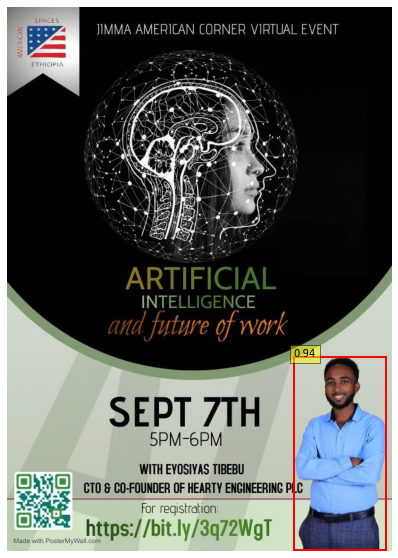

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLOv9 model
model = YOLO("yolov9c.pt")

def detect_and_show(image_path, model, conf_threshold=0.25):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return

    results = model.predict(image)  # Run inference

    # Display the image with detections
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for result in results:
        boxes = result.boxes.xyxy if hasattr(result, 'boxes') else []
        confidences = result.boxes.conf if hasattr(result.boxes, 'conf') else []

        for box, conf in zip(boxes, confidences):
            x_min, y_min, x_max, y_max = map(int, box[:4])
            print(f'conf: {conf}')
            if conf < conf_threshold:
                continue
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x_min, y_min, f'{conf:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Example usage
image_path = r'E:\VO\photo_2023-09-18_00-20-54.jpg'
detect_and_show(image_path, model)


In [1]:
from yolov9.models.yolo import Model

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

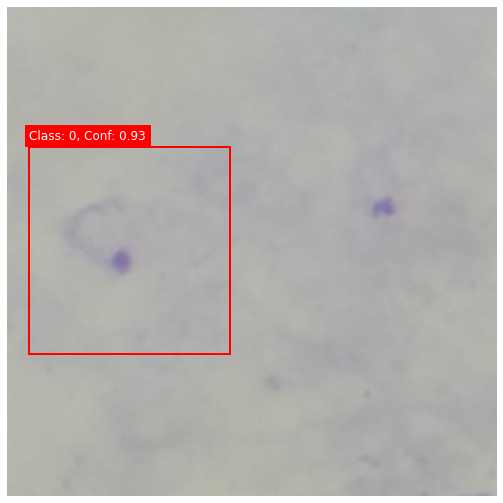

In [16]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox
from yolov9.utils.general import non_max_suppression, scale_boxes

def load_model(weights_path, cfg_path):
    checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
    model = Model(cfg=cfg_path, ch=3, nc=1)  # Ensure `nc` matches the number of classes in your model
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'].float().state_dict())
    else:
        raise TypeError("Invalid checkpoint format")
    return model

def detect_objects(image_path, model, conf_threshold=0.25, iou_threshold=0.45):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return []
    img = letterbox(image, new_shape=640)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x640x640
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float() / 255.0
    img = img.unsqueeze(0)  # Add batch dimension

    # Inference
    with torch.no_grad():
        results = model(img)
    detections = non_max_suppression(results, conf_threshold, iou_threshold, classes=None, agnostic=False)

    # Format detections
    det_list = []
    for det in detections[0]:  # Assuming the batch size is 1
        x1, y1, x2, y2, conf, cls = det
        if conf < conf_threshold:
            continue
        det_dict = {
            'bbox': (int(x1), int(y1), int(x2), int(y2)),
            'confidence': float(conf),
            'class_id': int(cls)
        }
        det_list.append(det_dict)

    return det_list

def show_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12, 9))

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch for each detection and add it to the plot
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = f"Class: {det['class_id']}, Conf: {det['confidence']:.2f}"
        ax.text(x1, y1 - 10, label, color='white', fontsize=12, backgroundcolor='red')

    # Remove axis information and show the plot
    plt.axis('off')
    plt.show()

weights_path = 'best.pt'
cfg_path = 'C:\\Users\\hp\\american\\yolov9\\models\\detect\\gelan-c.yaml'
model = load_model(weights_path, cfg_path)
image_path = 'tile_1.png'
detections = detect_objects(image_path, model)
show_detections(image_path, detections)


In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('best_model_mobilevit.h5')

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.__version__

'2.13.0'

In [4]:
import keras